# **Import Library**

In [1]:
import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Dense, Lambda, Flatten

2025-05-09 12:38:06.048974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746794286.275537      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746794286.343581      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Setup Distribusi Multi-GPU dengan MirroredStrategy
import tensorflow as tf

# Cek ulang ketersediaan GPU
physical_devices = tf.config.list_physical_devices('GPU')
print(f"GPU terdeteksi: {len(physical_devices)}")

# Setup distribusi multi-GPU
try:
    # Ini akan menggunakan semua GPU yang tersedia secara otomatis
    strategy = tf.distribute.MirroredStrategy()
    print(f"Training akan menggunakan {strategy.num_replicas_in_sync} GPU")
    
    # Aktifkan XLA compilation
    tf.config.optimizer.set_jit(True)
    
    # Aktifkan mixed precision
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision diaktifkan untuk mempercepat training")
    
    
except Exception as e:
    print(f"Error saat setup MirroredStrategy: {e}")
    strategy = None
    
print("Setup GPU selesai!")

GPU terdeteksi: 2
Training akan menggunakan 2 GPU
Mixed precision diaktifkan untuk mempercepat training
Setup GPU selesai!


I0000 00:00:1746794299.670450      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746794299.671123      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
# Periksa apakah GPU terdeteksi
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

# Aktifkan GPU memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled for", len(physical_devices), "devices")
    except:
        print("Error setting memory growth")

# Verifikasi penggunaan GPU
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
    c = tf.matmul(a, b)
    print("Matrix multiplication result:", c)
    print("Running on GPU:" if tf.test.is_gpu_available() else "Running on CPU:")

TensorFlow version: 2.18.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Error setting memory growth
Matrix multiplication result: tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)
Running on GPU:


I0000 00:00:1746794299.843928      31 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746794299.844161      31 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# **Import Dataset**

In [4]:
# Baca dataset MyAnimeList
df_user = pd.read_csv('/kaggle/input/myanimelist-dataset/users-details-2023.csv')
df_anime = pd.read_csv('/kaggle/input/myanimelist-dataset/anime-dataset-2023.csv')
df_score = pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv')

In [5]:
# data anime
print("Contoh Baris Terakhir, Panjang Dataset:",df_anime.shape)

print(df_anime.tail(10))

Contoh Baris Terakhir, Panjang Dataset: (24905, 24)
       anime_id                        Name                    English name  \
24895     55726                Die, Please!                         UNKNOWN   
24896     55727                        Miru                         UNKNOWN   
24897     55728  Wo Mengjian ni Mengjian wo  A Dream Where You Dreamt of Me   
24898     55729                    Thailand                         UNKNOWN   
24899     55730                      Energy                         UNKNOWN   
24900     55731                 Wu Nao Monu                         UNKNOWN   
24901     55732         Bu Xing Si: Yuan Qi                     Blader Soul   
24902     55733                 Di Yi Xulie                 The First Order   
24903     55734    Bokura no Saishuu Sensou                         UNKNOWN   
24904     55735              Shijuuku Nichi                         UNKNOWN   

      Other name    Score                              Genres  \
24895  부탁이니 죽

In [6]:
# data user details

# Tentukan jumlah total baris yang ingin Anda baca (10%)
total_rows_user = 731290
sample_size_user = int(total_rows_user * 0.04)

# Membaca hanya 10% dari data
df_user=pd.read_csv('/kaggle/input/myanimelist-dataset/users-details-2023.csv', nrows=sample_size_user)

# Tampilkan informasi mengenai dataframe yang dibaca
print(df_user.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29251 entries, 0 to 29250
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Mal ID            29251 non-null  int64  
 1   Username          29250 non-null  object 
 2   Gender            14250 non-null  object 
 3   Birthday          10262 non-null  object 
 4   Location          10486 non-null  object 
 5   Joined            29251 non-null  object 
 6   Days Watched      29250 non-null  float64
 7   Mean Score        29250 non-null  float64
 8   Watching          29250 non-null  float64
 9   Completed         29250 non-null  float64
 10  On Hold           29250 non-null  float64
 11  Dropped           29250 non-null  float64
 12  Plan to Watch     29250 non-null  float64
 13  Total Entries     29250 non-null  float64
 14  Rewatched         29250 non-null  float64
 15  Episodes Watched  29250 non-null  float64
dtypes: float64(10), int64(1), object(5)
memo

In [7]:
# Tampilkan baris terakhir dari dataframe
print("Contoh Baris Terakhir, Panjang Dataset:",df_user.shape)

print(df_user.tail(50))

Contoh Baris Terakhir, Panjang Dataset: (29251, 16)
       Mal ID          Username  Gender                   Birthday  \
29201   30673         Lizzipoos  Female  1990-10-18T00:00:00+00:00   
29202   30674  Armandthevampire    Male  1983-11-14T00:00:00+00:00   
29203   30675  tensa_zangetsu17    Male  1994-08-17T00:00:00+00:00   
29204   30676              kyst     NaN                        NaN   
29205   30677              Masa    Male  1977-12-02T00:00:00+00:00   
29206   30678      thinker82090    Male  1990-08-20T00:00:00+00:00   
29207   30679   Thunder_Emperor     NaN  1988-06-23T00:00:00+00:00   
29208   30680        lostvenus2     NaN                        NaN   
29209   30681             yo2ko     NaN                        NaN   
29210   30682        DarkIchigo     NaN                        NaN   
29211   30683       Firefreek22     NaN                        NaN   
29212   30684          gaara089     NaN                        NaN   
29213   30685         Supporter     Na

In [8]:
# data user score rating

# Tentukan jumlah total baris yang ingin Anda baca (10%)
total_rows_score = 24325191
sample_size_score = int(total_rows_score * 0.1)

# Membaca hanya 10% dari data
df_score = pd.read_csv('/kaggle/input/myanimelist-dataset/users-score-2023.csv', nrows=sample_size_score)

# Tampilkan informasi mengenai dataframe yang dibaca
print(df_score.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432519 entries, 0 to 2432518
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 92.8+ MB
None


In [9]:
# Tampilkan baris terakhir dari dataframe
print("Contoh Baris Terakhir, Panjang Dataset:",df_score.shape)

print(df_score.tail(10))

Contoh Baris Terakhir, Panjang Dataset: (2432519, 5)
         user_id Username  anime_id                          Anime Title  \
2432509    32542  Bocknoi        66         Azumanga Daiou The Animation   
2432510    32542  Bocknoi      7817                         B-gata H-kei   
2432511    32542  Bocknoi      2251                             Baccano!   
2432512    32542  Bocknoi      3901                    Baccano! Specials   
2432513    32542  Bocknoi      6347           Baka to Test to Shoukanjuu   
2432514    32542  Bocknoi      8516       Baka to Test to Shoukanjuu Ni!   
2432515    32542  Bocknoi      9471  Baka to Test to Shoukanjuu: Matsuri   
2432516    32542  Bocknoi      5081                       Bakemonogatari   
2432517    32542  Bocknoi      7674                             Bakuman.   
2432518    32542  Bocknoi      1576   Bakumatsu Kikansetsu Irohanihoheto   

         rating  
2432509       7  
2432510       7  
2432511       9  
2432512       7  
2432513       8  
24

In [10]:
# Data Final

# Menampilkan data dan jumlah baris untuk df_user
print("users_data.csv")
display(df_user.sample(3))
print(f"Jumlah data: {len(df_user)}\n")

# Menampilkan data dan jumlah baris untuk df_score
print("anime_rating.csv")
display(df_score.sample(3))
print(f"Jumlah data: {len(df_score)}\n")

# Menampilkan data dan jumlah baris untuk df_anime
print("anime_2023.csv")
display(df_anime.sample(3))
print(f"Jumlah data: {len(df_anime)}")

users_data.csv


,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
9658,10839,Revenant,Male,1988-07-21T00:00:00+00:00,Germany,2007-08-21T00:00:00+00:00,123.1,7.54,12.0,215.0,0.0,44.0,12.0,283.0,10.0,7350.0
9458,10637,knightshovel,NaN,NaN,NaN,2007-08-18T00:00:00+00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18410,19703,yukysaky,NaN,NaN,NaN,2007-11-01T00:00:00+00:00,9.8,6.74,1.0,18.0,0.0,0.0,2.0,21.0,0.0,578.0


Jumlah data: 29251

anime_rating.csv


,user_id,Username,anime_id,Anime Title,rating
795411,9610,Mr_Su,10495,Yuru Yuri,8
1005419,12629,susonauta,721,Princess Tutu,8
797490,9647,Chilischote,319,Happy World!,6


Jumlah data: 2432519

anime_2023.csv


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
23674,53899,Itsumo no Egao de,UNKNOWN,いつもの笑顔で,UNKNOWN,UNKNOWN,Music video for the song Itsumo no Egao de by ...,Music,1.0,"Apr 3, 1995",...,UNKNOWN,Original,2 min,G - All Ages,UNKNOWN,21951,0,UNKNOWN,63,https://cdn.myanimelist.net/images/anime/1859/...
11424,32716,Nihon no Otogibanashi,UNKNOWN,日本のおとぎばなし,UNKNOWN,"Fantasy, Supernatural",Various classic Japanese fairy tales told for ...,OVA,29.0,1990,...,UNKNOWN,Other,11 min per ep,G - All Ages,18508.0,18086,0,UNKNOWN,244,https://cdn.myanimelist.net/images/anime/11/79...
12072,33881,Kochira Katsushikaku Kameari Kouenmae Hashutsu...,UNKNOWN,こちら葛飾区亀有公園前派出所 ワシと俺!?〜ぼくらは浅草少年探偵団!〜,6.29,Comedy,An amazing time machine invention allows Ryout...,Special,2.0,"Apr 6, 2008 to Apr 13, 2008",...,Gallop,Manga,20 min per ep,PG-13 - Teens 13 or older,7455.0,14381,0,133.0,584,https://cdn.myanimelist.net/images/anime/6/815...


Jumlah data: 24905


# **Data Assessment**


## **`df_user`**

In [11]:
df_user.sample(5)

,Mal ID,Username,Gender,Birthday,Location,Joined,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
28829,30295,koolasapixels,NaN,NaN,NaN,2008-01-08T00:00:00+00:00,12.3,8.54,6.0,19.0,6.0,4.0,8.0,43.0,0.0,742.0
21356,22719,Nadjuset,NaN,NaN,NaN,2007-11-20T00:00:00+00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27326,28776,sakiwaki,NaN,NaN,NaN,2007-12-31T00:00:00+00:00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12060,13267,Nijuukyuu,Female,1990-05-04T00:00:00+00:00,In my mind.,2007-09-12T00:00:00+00:00,0.0,10.00,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
21320,22681,Zarashi,Male,1986-05-07T00:00:00+00:00,"Nashville, Tennessee",2007-11-19T00:00:00+00:00,112.9,8.89,6.0,206.0,7.0,0.0,151.0,370.0,47.0,6564.0


In [12]:
# View variable information in users data
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29251 entries, 0 to 29250
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Mal ID            29251 non-null  int64  
 1   Username          29250 non-null  object 
 2   Gender            14250 non-null  object 
 3   Birthday          10262 non-null  object 
 4   Location          10486 non-null  object 
 5   Joined            29251 non-null  object 
 6   Days Watched      29250 non-null  float64
 7   Mean Score        29250 non-null  float64
 8   Watching          29250 non-null  float64
 9   Completed         29250 non-null  float64
 10  On Hold           29250 non-null  float64
 11  Dropped           29250 non-null  float64
 12  Plan to Watch     29250 non-null  float64
 13  Total Entries     29250 non-null  float64
 14  Rewatched         29250 non-null  float64
 15  Episodes Watched  29250 non-null  float64
dtypes: float64(10), int64(1), object(5)
memo

In [13]:
# View the number of unique data in each users data variable
print("Number of unique data:")
print(df_user.nunique())

Number of unique data:
Mal ID              29251
Username            29250
Gender                  3
Birthday             4557
Location             5366
Joined                637
Days Watched         2734
Mean Score            546
Watching              253
Completed            1331
On Hold               233
Dropped               337
Plan to Watch         611
Total Entries        1642
Rewatched             332
Episodes Watched     8299
dtype: int64


In [14]:
# See the number of empty data in each users data variable
print("Number of empty data:")
print(df_user.isna().sum())

Number of empty data:
Mal ID                  0
Username                1
Gender              15001
Birthday            18989
Location            18765
Joined                  0
Days Watched            1
Mean Score              1
Watching                1
Completed               1
On Hold                 1
Dropped                 1
Plan to Watch           1
Total Entries           1
Rewatched               1
Episodes Watched        1
dtype: int64


In [15]:
# View the number of duplicate data in each row of seller data
print("Number of duplicate rows:", end=" ")
print(df_user.duplicated().sum())

Number of duplicate rows: 0


In [16]:
# View descriptive parameter data from each numeric variable of seller data
df_user.describe()

,Mal ID,Days Watched,Mean Score,Watching,Completed,On Hold,Dropped,Plan to Watch,Total Entries,Rewatched,Episodes Watched
count,29251.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,29250.000000,2.925000e+04
mean,15865.707736,42.441597,5.797398,8.512171,120.665607,8.110940,10.979111,27.399897,175.667863,10.348239,2.750476e+03
std,8590.015217,71.396812,3.663775,26.394737,266.508313,46.138766,41.820468,108.352912,364.098219,43.193118,1.028980e+04
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,8457.500000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000e+00
50%,15865.000000,14.800000,7.500000,2.000000,23.000000,0.000000,0.000000,1.000000,37.000000,0.000000,8.855000e+02
75%,23306.500000,55.500000,8.310000,8.000000,126.000000,6.000000,6.000000,16.000000,194.000000,5.000000,3.330750e+03
max,30722.000000,2410.700000,10.000000,1062.000000,7893.000000,5167.000000,2522.000000,6440.000000,10178.000000,3498.000000,1.198076e+06


## **`df_anime`**

In [17]:
df_anime.sample(3)

,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
852,941,Renkin San-kyuu Magical? Pokaan,UNKNOWN,錬金3級 まじかる?ぽか〜ん,6.98,"Comedy, Ecchi",Renkin San-kyuu Magical? Pokaan follows the da...,TV,12.0,"Apr 4, 2006 to Jun 20, 2006",...,Remic,Original,23 min per ep,R+ - Mild Nudity,4081.0,3685,135,10012.0,31953,https://cdn.myanimelist.net/images/anime/6/752...
10018,29535,Hello Kitty no Hajimete no Christmas Cake,UNKNOWN,ハローキティのはじめてのクリスマスケーキ,UNKNOWN,UNKNOWN,Kitty and Mimmy try to bake a Christmas cake f...,OVA,1.0,"Oct 21, 1998",...,UNKNOWN,Unknown,17 min,G - All Ages,16397.0,16045,0,UNKNOWN,387,https://cdn.myanimelist.net/images/anime/9/709...
9462,26229,Kaze no Tabibito,UNKNOWN,風の旅人,UNKNOWN,Drama,An educational film about wheel-chair bound pe...,OVA,1.0,2003,...,UNKNOWN,Unknown,30 min,G - All Ages,17205.0,19468,0,UNKNOWN,166,https://cdn.myanimelist.net/images/anime/4/661...


In [18]:
# View variable information in tourism data
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   anime_id      24905 non-null  int64 
 1   Name          24905 non-null  object
 2   English name  24905 non-null  object
 3   Other name    24905 non-null  object
 4   Score         24905 non-null  object
 5   Genres        24905 non-null  object
 6   Synopsis      24905 non-null  object
 7   Type          24905 non-null  object
 8   Episodes      24905 non-null  object
 9   Aired         24905 non-null  object
 10  Premiered     24905 non-null  object
 11  Status        24905 non-null  object
 12  Producers     24905 non-null  object
 13  Licensors     24905 non-null  object
 14  Studios       24905 non-null  object
 15  Source        24905 non-null  object
 16  Duration      24905 non-null  object
 17  Rating        24905 non-null  object
 18  Rank          24905 non-null  object
 19  Popu

In [19]:
# View the number of unique data in each tourism data variable
print("Number of unique data:")
print(df_anime.nunique())

Number of unique data:
anime_id        24905
Name            24901
English name    10134
Other name      23796
Score             567
Genres           1006
Synopsis        20113
Type                7
Episodes          252
Aired           15213
Premiered         244
Status              3
Producers        4423
Licensors         265
Studios          1547
Source             17
Duration          331
Rating              7
Rank            15198
Popularity      18363
Favorites        1814
Scored By        8281
Members         10996
Image URL       24720
dtype: int64


In [20]:
# See the number of empty data in each tourism data variable
print("Number of empty data:")
print(df_anime.isna().sum())

Number of empty data:
anime_id        0
Name            0
English name    0
Other name      0
Score           0
Genres          0
Synopsis        0
Type            0
Episodes        0
Aired           0
Premiered       0
Status          0
Producers       0
Licensors       0
Studios         0
Source          0
Duration        0
Rating          0
Rank            0
Popularity      0
Favorites       0
Scored By       0
Members         0
Image URL       0
dtype: int64


In [21]:
# View the number of duplicate data in each row of tourism data
print("Number of duplicate rows:", end=" ")
print(df_anime.duplicated().sum())

Number of duplicate rows: 0


In [22]:
# View all unique genres
genres_set = set()
for data in df_anime['Genres'].tolist():
  genres = data.split(', ')
  for genre in genres:
    genres_set.add(genre)

print(f'Number of genres: {len(genres_set)}')
for index, data in enumerate(genres_set):
  print(index, data)

Number of genres: 22
0 UNKNOWN
1 Girls Love
2 Suspense
3 Avant Garde
4 Action
5 Fantasy
6 Slice of Life
7 Drama
8 Erotica
9 Sci-Fi
10 Ecchi
11 Comedy
12 Supernatural
13 Romance
14 Mystery
15 Horror
16 Adventure
17 Sports
18 Award Winning
19 Gourmet
20 Hentai
21 Boys Love


In [23]:
# View descriptive parameter data of each numeric variable of customer data
df_anime.describe()

,anime_id,Popularity,Favorites,Members
count,24905.000000,24905.000000,24905.000000,2.490500e+04
mean,29776.709014,12265.388356,432.595222,3.710496e+04
std,17976.076290,7187.428393,4353.181647,1.568252e+05
min,1.000000,0.000000,0.000000,0.000000e+00
25%,10507.000000,6040.000000,0.000000,2.090000e+02
50%,34628.000000,12265.000000,1.000000,1.056000e+03
75%,45240.000000,18491.000000,18.000000,9.326000e+03
max,55735.000000,24723.000000,217606.000000,3.744541e+06


## **`df_score`**

In [24]:
df_score.sample(3)

,user_id,Username,anime_id,Anime Title,rating
1704369,22684,Puchuu,158,Maria-sama ga Miteru,9
1430366,18996,Echoes,23233,Shinmai Maou no Testament,5
1963094,26128,momoodar,199,Sen to Chihiro no Kamikakushi,10


In [25]:
# View variable information in rating data
df_score.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2432519 entries, 0 to 2432518
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   user_id      int64 
 1   Username     object
 2   anime_id     int64 
 3   Anime Title  object
 4   rating       int64 
dtypes: int64(3), object(2)
memory usage: 92.8+ MB


In [26]:
# View the number of unique data in each rating data variable
print("Number of unique data:")
print(df_score.nunique())

Number of unique data:
user_id        21545
Username       21544
anime_id       12939
Anime Title    12936
rating            10
dtype: int64


In [27]:
# See the number of empty data in each rating data variable
print("Number of empty data:")
print(df_score.isna().sum())

Number of empty data:
user_id          0
Username       232
anime_id         0
Anime Title      0
rating           0
dtype: int64


In [28]:
# View the number of duplicate data in each row of rating data
print("Number of duplicate rows:", end=" ")
print(df_score.duplicated().sum())

Number of duplicate rows: 0


In [29]:
# View descriptive parameter data of each numeric variable of rating data
df_score.describe()

,user_id,anime_id,rating
count,2.432519e+06,2.432519e+06,2.432519e+06
mean,1.589589e+04,7.045320e+03,7.488476e+00
std,9.540486e+03,1.117115e+04,1.651532e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,7.172000e+03,4.400000e+02,7.000000e+00
50%,1.587900e+04,1.785000e+03,8.000000e+00
75%,2.424700e+04,7.668000e+03,9.000000e+00
max,3.254200e+04,5.564700e+04,1.000000e+01


# **Data Cleaning**

## **`df_user`**

In [30]:
# Only keep necessary columns
df_user = df_user[['Mal ID', 'Username']].copy()
df_user.head(3)

,Mal ID,Username
0,1,Xinil
1,3,Aokaado
2,4,Crystal


## **`df_anime`**

In [31]:
# Mengambil kolom yang relevan untuk anime termasuk Producers dan Studios
columns_anime = ['anime_id', 'Name', 'Genres', 'Score', 'Status', 'Favorites']
df_anime = df_anime[columns_anime].copy()
df_anime.head(3)

,anime_id,Name,Genres,Score,Status,Favorites
0,1,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,Finished Airing,78525
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Sci-Fi",8.38,Finished Airing,1448
2,6,Trigun,"Action, Adventure, Sci-Fi",8.22,Finished Airing,15035


In [32]:
# Convert Rating columns with commas to proper float format
df_anime['Score'] = df_anime['Score'].replace('UNKNOWN', np.nan)
df_anime['Score'] = df_anime['Score'].replace(',', '.', regex=True)
df_anime['Score'] = df_anime['Score'].astype(dtype='float32')
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24905 entries, 0 to 24904
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   anime_id   24905 non-null  int64  
 1   Name       24905 non-null  object 
 2   Genres     24905 non-null  object 
 3   Score      15692 non-null  float32
 4   Status     24905 non-null  object 
 5   Favorites  24905 non-null  int64  
dtypes: float32(1), int64(2), object(3)
memory usage: 1.0+ MB


In [33]:
# Fill missing Time_Minutes with the median
# df_anime.fillna({'Time_Minutes': df_anime['Time_Minutes'].median()}, inplace=True)

## **`df_score`**

In [34]:
# Only keep necessary columns
df_score = df_score[['user_id', 'anime_id', 'rating']].copy()
df_score.head(3)

,user_id,anime_id,rating
0,1,21,9
1,1,48,7
2,1,320,5


# **Data Preprocessing**

## **Create sparse matrix representation for ratings**

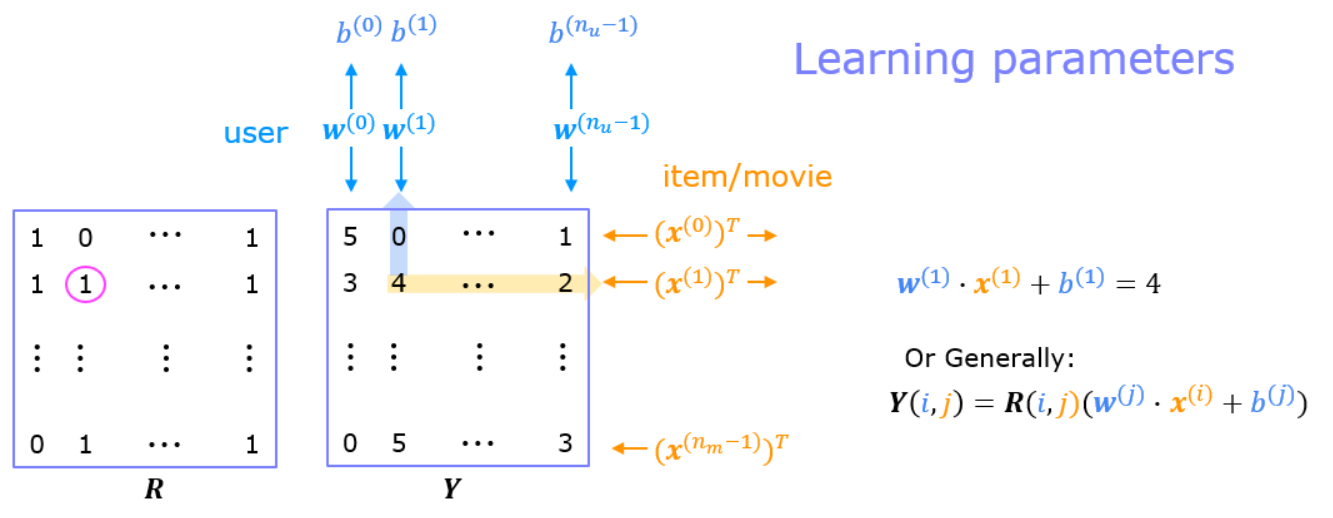

In [35]:
# mengidentifikasi semua user dan anime unik

print("Creating user-item interaction matrix...")
unique_users = df_score['user_id'].unique()
unique_animes = df_anime['anime_id'].unique()
print(f"Jumlah users unik: {len(unique_users)}")
print(f"Jumlah anime unik: {len(unique_animes)}")

Creating user-item interaction matrix...
Jumlah users unik: 21545
Jumlah anime unik: 24905


In [36]:
# Create mappings for user_id and anime_id to matrix indices
user_to_index = {user: i for i, user in enumerate(unique_users)}
anime_to_index = {anime: i for i, anime in enumerate(unique_animes)}
index_to_user = {i: user for user, i in user_to_index.items()}
index_to_anime = {i: anime for anime, i in anime_to_index.items()}

In [37]:
# Create data matrix for the DMF model
num_users = len(unique_users)
num_animes = len(unique_animes)
# Gunakan sparse matrix untuk efisiensi memori
from scipy import sparse
data_matrix = sparse.lil_matrix((num_users, num_animes))

In [38]:
# Fill in the data matrix with ratings
print("Filling interaction matrix with ratings...")
# Ekstrak data sekali saja untuk menghindari akses berulang
user_ids = df_score['user_id'].values
anime_ids = df_score['anime_id'].values
ratings_original = df_score['rating'].values

# Hitung statistik per user untuk normalisasi yang lebih baik
user_ratings = {}
for user_id, rating in zip(user_ids, ratings_original):
    if user_id not in user_ratings:
        user_ratings[user_id] = []
    user_ratings[user_id].append(rating)

# Hitung mean dan std setiap user untuk normalisasi
user_stats = {}
for user_id, ratings_list in user_ratings.items():
    user_stats[user_id] = {
        'mean': np.mean(ratings_list),
        'std': max(np.std(ratings_list), 0.1),  # Hindari pembagian dengan 0
        'min': min(ratings_list),
        'max': max(ratings_list)
    }

# Set seed untuk konsistensi
np.random.seed(42)

# Normalisasi ratings - kembali ke range [0.2, 0.8] dengan teknik yang dioptimalkan
normalized_ratings = []
for i, (user_id, rating) in enumerate(zip(user_ids, ratings_original)):
    if user_id in user_stats:
        # Normalisasi Z-score terlebih dahulu
        user_mean = user_stats[user_id]['mean']
        user_std = user_stats[user_id]['std']
        z_score = (rating - user_mean) / user_std
        
        # Clip z-score ke range (-2.0 sampai 2.0) - lebih ketat
        z_score = np.clip(z_score, -2.0, 2.0)
        
        # Map z-score ke rentang [0.2, 0.8]
        norm_rating = 0.2 + (z_score + 2.0) * (0.6 / 4.0)
        
        # Noise yang lebih besar dan lebih sering (20% data)
        if np.random.random() < 0.2:
            noise = np.random.normal(0, 0.06)  # Noise lebih signifikan
            norm_rating = np.clip(norm_rating + noise, 0.2, 0.8)
    else:
        # Default normalisasi jika user baru
        norm_rating = 0.2 + (rating - 1) * (0.6 / 9.0)
        
    normalized_ratings.append(norm_rating)

# Konversi ke array untuk operasi yang lebih cepat
ratings = np.array(normalized_ratings)

# Proses dalam satu batch dengan numpy untuk kecepatan
user_indices = np.array([user_to_index.get(u) for u in user_ids])
anime_indices = np.array([anime_to_index.get(a) for a in anime_ids])

# Filter out None values dengan vectorized operation yang lebih cepat
mask = np.logical_and(user_indices != None, anime_indices != None)
valid_users = user_indices[mask]
valid_items = anime_indices[mask]
valid_ratings = ratings[mask]

# Construct sparse matrix in COO format directly (lebih cepat)
data_matrix = sparse.coo_matrix(
    (valid_ratings, (valid_users, valid_items)),
    shape=(num_users, num_animes)
)

# Konversi ke format CSR untuk operasi yang lebih cepat
data_matrix = data_matrix.tocsr()

print(f"Data matrix shape: {data_matrix.shape}")
print(f"Range normalisasi: Min={np.min(valid_ratings):.4f}, Max={np.max(valid_ratings):.4f}, Mean={np.mean(valid_ratings):.4f}")

Filling interaction matrix with ratings...
Data matrix shape: (21545, 24905)
Range normalisasi: Min=0.2000, Max=0.8000, Mean=0.5027


In [39]:
# Melihat struktur data matrix
print("Shape:", data_matrix.shape)
print("Density: {:.4f}%".format(100 * data_matrix.count_nonzero() / (data_matrix.shape[0] * data_matrix.shape[1])))

# Konversi sebagian kecil data ke format array untuk visualisasi
sample_size = min(5, data_matrix.shape[0])
print("\nSample dari data matrix (5 user pertama x 10 anime pertama):")
print(data_matrix[:sample_size, :10].toarray())

# Contoh nilai rating user pertama
nonzero_idx = data_matrix[0].nonzero()[1]
if len(nonzero_idx) > 0:
    print("\nBeberapa rating dari user pertama:")
    for idx in nonzero_idx[:5]:
        print(f"Anime {idx}: {data_matrix[0, idx]}")

Shape: (21545, 24905)
Density: 0.4533%

Sample dari data matrix (5 user pertama x 10 anime pertama):
[[0.78075887 0.56150753 0.66872296 0.6711332  0.34225619 0.45188186
  0.60924326 0.45188186 0.56150753 0.6711332 ]
 [0.6308118  0.74338205 0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.52284464 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.60635942 0.49355397 0.49355397 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.68357862 0.56456903 0.56456903 0.         0.         0.44555944
  0.         0.         0.44555944 0.        ]]

Beberapa rating dari user pertama:
Anime 0: 0.7807588724875791
Anime 1: 0.5615075324227633
Anime 2: 0.6687229609320743
Anime 3: 0.6711332024551713
Anime 4: 0.34225619235794735


In [40]:
# Ambil sampel 1000 rating untuk perbandingan
np.random.seed(42)  # Untuk hasil yang konsisten
sample_idx = np.random.choice(len(ratings_original), size=1000, replace=False)
original_sample = [ratings_original[i] for i in sample_idx]
normalized_sample = [normalized_ratings[i] for i in sample_idx]

# Buat DataFrame untuk mempermudah analisis
comparison_df = pd.DataFrame({
    'Rating_Asli': original_sample,
    'Rating_Normalisasi': normalized_sample
})

# Statistik deskriptif
stats = comparison_df.describe().round(4)
print("Statistik Rating Asli vs Normalisasi:")
print(stats)

# Distribusi rating asli (count per nilai)
print("\nDistribusi Rating Asli:")
original_counts = pd.Series(original_sample).value_counts().sort_index()
for rating, count in original_counts.items():
    percentage = (count / len(original_sample)) * 100
    print(f"Rating {rating}: {count} ({percentage:.2f}%)")

# Distribusi rating normalisasi (per interval)
print("\nDistribusi Rating Normalisasi:")
bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
bin_labels = ['0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
normalized_binned = pd.cut(normalized_sample, bins=bins, labels=bin_labels)
normalized_counts = normalized_binned.value_counts().sort_index()
for interval, count in normalized_counts.items():
    percentage = (count / len(normalized_sample)) * 100
    print(f"Range {interval}: {count} ({percentage:.2f}%)")

# Korelasi antara rating asli dan normalisasi
correlation = comparison_df.corr().iloc[0, 1]
print(f"\nKorelasi antara Rating Asli dan Normalisasi: {correlation:.4f}")

# Tabel transformasi: rating asli -> rata-rata nilai normalisasi
print("\nTransformasi Rating Asli ke Normalisasi:")
transformation = comparison_df.groupby('Rating_Asli')['Rating_Normalisasi'].agg(['mean', 'std', 'count']).round(4)
print(transformation)

Statistik Rating Asli vs Normalisasi:
       Rating_Asli  Rating_Normalisasi
count    1000.0000           1000.0000
mean        7.5170              0.5027
std         1.5774              0.1411
min         1.0000              0.2000
25%         7.0000              0.4026
50%         8.0000              0.5078
75%         9.0000              0.6100
max        10.0000              0.8000

Distribusi Rating Asli:
Rating 1: 2 (0.20%)
Rating 2: 5 (0.50%)
Rating 3: 11 (1.10%)
Rating 4: 21 (2.10%)
Rating 5: 60 (6.00%)
Rating 6: 120 (12.00%)
Rating 7: 251 (25.10%)
Rating 8: 253 (25.30%)
Rating 9: 183 (18.30%)
Rating 10: 94 (9.40%)

Distribusi Rating Normalisasi:
Range 0.1-0.2: 25 (2.50%)
Range 0.2-0.3: 67 (6.70%)
Range 0.3-0.4: 149 (14.90%)
Range 0.4-0.5: 243 (24.30%)
Range 0.5-0.6: 242 (24.20%)
Range 0.6-0.7: 202 (20.20%)
Range 0.7-0.8: 72 (7.20%)
Range 0.8-0.9: 0 (0.00%)
Range 0.9-1.0: 0 (0.00%)

Korelasi antara Rating Asli dan Normalisasi: 0.8308

Transformasi Rating Asli ke Normalisasi:
  

# **Data Splitting**

In [41]:
# Prepare Training, Validation, and Testing Data (optimized)
from sklearn.model_selection import train_test_split
print("Preparing training, validation, and test data...")

# Set seed untuk reproducibility
np.random.seed(42)

# Langsung menggunakan format COO yang lebih efisien
coo_matrix = data_matrix.tocoo()
ratings = np.column_stack((coo_matrix.row, coo_matrix.col, coo_matrix.data))

# Gunakan random_state berbeda untuk train dan val split
random_state_test = 42
random_state_val = 24  # Nilai yang berbeda
test_size = 0.1  # Test size 10%
val_size = 0.15  # Validation size ditingkatkan ke 15%

# Buat kategori rating yang lebih detail untuk stratifikasi lebih baik
# Perbarui bins untuk range normalisasi [0.2-0.8]
rating_bins = np.round((coo_matrix.data - 0.2) * 10).astype(int)

# Tambahkan stratifikasi berdasarkan pengguna dan item untuk distribusi yang lebih seimbang
# Buat user dan item bins yang lebih sederhana untuk stratifikasi yang lebih efektif
user_bins = np.clip(coo_matrix.row % 10, 0, 9)  # Mod 10 untuk mengurangi jumlah bins
item_bins = np.clip(coo_matrix.col % 20, 0, 19)  # Mod 20 untuk mengurangi jumlah bins

# Gabungkan semua stratifikasi menjadi satu label
combined_strat = rating_bins * 100 + user_bins * 10 + item_bins
# Limit jumlah kategori untuk stratifikasi yang lebih efektif
_, combined_strat = np.unique(combined_strat, return_inverse=True)

# Split dengan stratifikasi yang lebih baik
train_val_ratings, test_ratings = train_test_split(
    ratings, test_size=test_size, random_state=random_state_test,
    stratify=combined_strat if len(np.unique(combined_strat)) > 1 else None,
    shuffle=True
)

# Perbarui stratifikasi untuk validation split
val_rating_bins = np.round((train_val_ratings[:, 2] - 0.2) * 10).astype(int)
val_user_bins = np.clip(train_val_ratings[:, 0].astype(int) % 10, 0, 9)
val_item_bins = np.clip(train_val_ratings[:, 1].astype(int) % 20, 0, 19)
val_combined_strat = val_rating_bins * 100 + val_user_bins * 10 + val_item_bins
_, val_combined_strat = np.unique(val_combined_strat, return_inverse=True)

# Validation split yang lebih stratified
train_ratings, val_ratings = train_test_split(
    train_val_ratings, test_size=val_size/(1-test_size), random_state=random_state_val,
    stratify=val_combined_strat if len(np.unique(val_combined_strat)) > 1 else None,
    shuffle=True
)

print(f"Number of training samples: {len(train_ratings)}")
print(f"Number of validation samples: {len(val_ratings)}")
print(f"Number of test samples: {len(test_ratings)}")

# Periksa distribusi rating di setiap set
print("\nDistribusi rating (sampel):")
# Perbarui range histogram untuk normalisasi [0.2, 0.8]
bins = 6  # 6 bins untuk rentang 0.2-0.8
train_dist = np.histogram(train_ratings[:, 2], bins=bins, range=(0.2, 0.8))[0] / len(train_ratings)
val_dist = np.histogram(val_ratings[:, 2], bins=bins, range=(0.2, 0.8))[0] / len(val_ratings)
test_dist = np.histogram(test_ratings[:, 2], bins=bins, range=(0.2, 0.8))[0] / len(test_ratings)

for i, (tr, vl, ts) in enumerate(zip(train_dist, val_dist, test_dist)):
    bin_start = 0.2 + i * (0.6/bins)
    bin_end = bin_start + (0.6/bins)
    bin_range = f"{bin_start:.1f}-{bin_end:.1f}"
    print(f"Rating {bin_range}: Train={tr:.3f}, Val={vl:.3f}, Test={ts:.3f}")

# Tambahkan verifikasi keseimbangan data
print("\nDistribusi pengguna dan item:")
train_users = len(np.unique(train_ratings[:, 0]))
val_users = len(np.unique(val_ratings[:, 0]))
test_users = len(np.unique(test_ratings[:, 0]))
train_items = len(np.unique(train_ratings[:, 1]))
val_items = len(np.unique(val_ratings[:, 1]))
test_items = len(np.unique(test_ratings[:, 1]))
print(f"Users - Train: {train_users}, Val: {val_users}, Test: {test_users}")
print(f"Items - Train: {train_items}, Val: {val_items}, Test: {test_items}")

# Verifikasi statistik rating
train_mean = np.mean(train_ratings[:, 2])
val_mean = np.mean(val_ratings[:, 2])
test_mean = np.mean(test_ratings[:, 2])
print(f"Mean rating - Train: {train_mean:.4f}, Val: {val_mean:.4f}, Test: {test_mean:.4f}")

Preparing training, validation, and test data...
Number of training samples: 1824389
Number of validation samples: 364878
Number of test samples: 243252

Distribusi rating (sampel):
Rating 0.2-0.3: Train=0.097, Val=0.096, Test=0.097
Rating 0.3-0.4: Train=0.142, Val=0.143, Test=0.142
Rating 0.4-0.5: Train=0.231, Val=0.231, Test=0.232
Rating 0.5-0.6: Train=0.260, Val=0.260, Test=0.260
Rating 0.6-0.7: Train=0.189, Val=0.190, Test=0.188
Rating 0.7-0.8: Train=0.080, Val=0.080, Test=0.081

Distribusi pengguna dan item:
Users - Train: 21054, Val: 18037, Test: 17098
Items - Train: 12428, Val: 9612, Test: 8934
Mean rating - Train: 0.5027, Val: 0.5028, Test: 0.5026


In [42]:
def get_test_negatives(test_ratings, data_matrix, num_negatives=20):
   """
   # Membuat sampel negatif untuk evaluasi dengan optimasi memori dan kecepatan
   # Tujuan: Untuk setiap user-item positif, temukan item yang belum dirating untuk evaluasi
   """
   test_users = []
   test_items = []
   
   # Gunakan CSR format untuk akses row efisien
   data_matrix_csr = data_matrix.tocsr() if not isinstance(data_matrix, sparse.csr_matrix) else data_matrix
   
   # Hitung item popularity untuk sampling yang lebih realistis
   item_counts = np.array(data_matrix_csr.sum(axis=0)).flatten()
   popular_items = np.where(item_counts > np.percentile(item_counts, 75))[0]
   
   # Pre-generate random indices dengan campuran item populer dan random
   num_items = data_matrix.shape[1]
   random_indices = np.random.randint(0, num_items, size=(len(test_ratings), num_negatives*2))
   # Tambahkan beberapa item populer ke kandidat negatif (lebih realistis)
   popular_indices = np.random.choice(popular_items, size=(len(test_ratings), num_negatives), replace=True)
   
   # Pra-alokasi memory untuk menyimpan rated items per user
   user_rated_dict = {}
   
   # Batch process entries
   for idx, entry in enumerate(test_ratings):
       user, item, _ = entry
       user = int(user)
       item = int(item)
       test_users.append(user)
       
       # Get rated items for this user (dengan caching)
       if user not in user_rated_dict:
           user_rated_dict[user] = set(data_matrix_csr[user].nonzero()[1])
       user_rated = user_rated_dict[user]
       
       # Proses kandidat negatif dengan kombinasi random dan populer
       neg_items = []
       # Gabungkan random dan popular items (50/50)
       candidates = np.concatenate([random_indices[idx], popular_indices[idx]])
       mask = np.isin(candidates, list(user_rated), invert=True) & (candidates != item)
       valid_candidates = candidates[mask]
       
       # Ambil sebanyak yang dibutuhkan
       if len(valid_candidates) >= num_negatives:
           neg_items = valid_candidates[:num_negatives].tolist()
       else:
           # Gunakan semua valid candidates yang ada
           neg_items = valid_candidates.tolist()
           
           # Generate tambahan jika masih kurang
           needed = num_negatives - len(neg_items)
           if needed > 0:
               extra_candidates = set(neg_items)
               while len(neg_items) < num_negatives:
                   # Pilih dari item populer atau random dengan probabilitas 50/50
                   if np.random.random() < 0.5 and len(popular_items) > 0:
                       candidate = np.random.choice(popular_items)
                   else:
                       candidate = np.random.randint(0, num_items)
                   
                   if candidate not in user_rated and candidate != item and candidate not in extra_candidates:
                       neg_items.append(candidate)
                       extra_candidates.add(candidate)
       
       all_items = [item] + neg_items
       test_items.append(all_items)
   
   return [test_users, test_items]

In [43]:
# Generate negative samples untuk testing dengan pendekatan yang lebih efisien
# Membuat daftar item negatif untuk setiap user-item positif dalam data test
import time
start_time = time.time()

# Pastikan matrix dalam format yang efisien
if not isinstance(data_matrix, sparse.csr_matrix):
   data_matrix = data_matrix.tocsr()

# Tambahkan seed untuk hasil yang konsisten
np.random.seed(42)  
test_negatives = get_test_negatives(test_ratings, data_matrix)

print(f"Generated negative samples for {len(test_negatives[0])} test users in {time.time() - start_time:.2f} seconds")
print(f"Average number of negative items per user: {len(test_negatives[1][0]) - 1}")

Generated negative samples for 243252 test users in 34.79 seconds
Average number of negative items per user: 20


In [44]:
# Tampilkan contoh hasil negative sampling dengan nama anime
if len(test_negatives[0]) > 0:
    sample_idx = 0  # Contoh pertama
    user_id = test_negatives[0][sample_idx]
    pos_anime_id = test_negatives[1][sample_idx][0]
    neg_anime_ids = test_negatives[1][sample_idx][1:6]
    
    # Dapatkan nama anime dari id
    pos_anime_name = df_anime[df_anime['anime_id'] == pos_anime_id]['Name'].values[0] if len(df_anime[df_anime['anime_id'] == pos_anime_id]) > 0 else "Unknown"
    
    print("\nContoh hasil negative sampling:")
    print(f"User ID: {user_id}")
    print(f"Item positif: {pos_anime_id} ({pos_anime_name})")
    print(f"5 item negatif (ID): {neg_anime_ids}")


Contoh hasil negative sampling:
User ID: 1869
Item positif: 818 (Sakura Tsuushin)
5 item negatif (ID): [23654, 15795, 860, 5390, 21575]


# **Deep Matrix Factorization Model**

## **DeepMF**

In [45]:
class DMF:
  def __init__(self,
               num_users,
               num_items,
               user_layers,
               item_layers,
               lr,
               train_matrix):
      self.num_users = num_users
      self.num_items = num_items
      self.user_layers = user_layers
      self.item_layers = item_layers
      self.lr = lr
      self.train_matrix = train_matrix
      # Cache model untuk inference yang lebih cepat
      self._model = None
  
  @staticmethod
  def init_normal(shape, dtype=None):
      # Kurangi stddev untuk inisialisasi weight yang lebih stabil
      return tf.random.normal(shape=shape, stddev=0.005, dtype=dtype)
  
  @staticmethod
  def cosine_similarity(inputs, epsilon=1e-5, delta=1e-8):
      x, y = inputs[0], inputs[1]
      # Vectorized operations yang lebih efisien
      numerator = tf.reduce_sum(x * y, axis=1, keepdims=True)
      # Gunakan operasi paralel untuk perhitungan denominator
      x_squared_norm = tf.reduce_sum(tf.square(x), axis=1, keepdims=True)
      y_squared_norm = tf.reduce_sum(tf.square(y), axis=1, keepdims=True)
      denominator = tf.sqrt(x_squared_norm * y_squared_norm + delta) 
      
      # Stabilitas numerik yang lebih baik
      return tf.clip_by_value(numerator / denominator, epsilon, 1.0 - epsilon)
  
  def get_model(self):
      # Return cached model jika sudah dibuat
      if self._model is not None:
          return self._model
          
      # Gunakan keras functional API
      user_input = Input(shape=(1,), dtype='int32', name='user_input')
      item_input = Input(shape=(1,), dtype='int32', name='item_input')
      
      # Embedding dengan ukuran output yang optimal
      embed_dim = min(128, min(self.num_items, self.num_users) // 10)
      
      # Tingkatkan regularisasi embedding
      user_embedding = Embedding(
          input_dim=self.num_users,
          output_dim=embed_dim,
          embeddings_initializer='normal',
          embeddings_regularizer=tf.keras.regularizers.l2(5e-5),  # Ditingkatkan
          name='user_embedding'
      )(user_input)
      
      item_embedding = Embedding(
          input_dim=self.num_items,
          output_dim=embed_dim,
          embeddings_initializer='normal',
          embeddings_regularizer=tf.keras.regularizers.l2(5e-5),  # Ditingkatkan
          name='item_embedding'
      )(item_input)
      
      # Flatten untuk proses transformasi
      user_vector = Flatten()(user_embedding)
      item_vector = Flatten()(item_embedding)
      
      # Tambahkan batch normalization di awal (opsional)
      user_vector = BatchNormalization()(user_vector)
      item_vector = BatchNormalization()(item_vector)
      
      # User layers stack dengan dropout yang lebih tinggi
      for i in range(len(self.user_layers)):
          user_vector = Dense(
              self.user_layers[i],
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(3e-3),  # Ditingkatkan
              kernel_initializer=self.init_normal,
              bias_initializer=self.init_normal,
              name=f'user_layer{i+1}'
          )(user_vector)
          
          # Gunakan dropout yang lebih tinggi untuk regularisasi yang lebih kuat
          dropout_rate = 0.25 if i == len(self.user_layers)-1 else 0.35
          user_vector = Dropout(dropout_rate)(user_vector)
      
      # Item layers dengan regularisasi yang sama
      for i in range(len(self.item_layers)):
          item_vector = Dense(
              self.item_layers[i],
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(3e-3),  # Ditingkatkan
              kernel_initializer=self.init_normal,
              bias_initializer=self.init_normal,
              name=f'item_layer{i+1}'
          )(item_vector)
          
          dropout_rate = 0.25 if i == len(self.item_layers)-1 else 0.35
          item_vector = Dropout(dropout_rate)(item_vector)
      
      # Compute similarity dengan lambda layer yang dioptimalkan
      predict = Lambda(
          function=self.cosine_similarity,
          name='predict'
      )([user_vector, item_vector])
      
      # Buat model dan compile
      self._model = Model(inputs=[user_input, item_input], outputs=predict)
      
      # Gunakan optimizer yang dioptimalkan dengan learning rate lebih kecil
      optimizer = optimizers.Adam(
          learning_rate=self.lr,
          beta_1=0.9,
          beta_2=0.999,
          epsilon=1e-7
      )
      
      self._model.compile(
          optimizer=optimizer,
          loss='binary_crossentropy',
          metrics=['mean_absolute_error']
      )
      
      return self._model

In [46]:
def get_train_instances_fast(train_ratings, num_negatives, num_items=None):
   """
   Membuat instance training dengan positive dan negative sampling yang optimized
   """
   if num_items is None:
       num_items = data_matrix.shape[1]
   
   # Set seed untuk konsistensi
   np.random.seed(42)
   
   # Vectorized extraction dari train_ratings
   users = np.array([int(r[0]) for r in train_ratings], dtype=np.int32)
   items = np.array([int(r[1]) for r in train_ratings], dtype=np.int32)
   
   # Tambahkan noise kecil ke ratings untuk regularisasi natural
   ratings_orig = np.array([float(r[2]) for r in train_ratings], dtype=np.float32)
   ratings = np.clip(ratings_orig + np.random.uniform(-0.02, 0.02, len(ratings_orig)), 0.2, 0.8)
   
   # Pre-alokasi dengan ukuran maksimum yang diperlukan
   n_samples = len(train_ratings) * (1 + num_negatives)
   user_input = np.zeros(n_samples, dtype=np.int32)
   item_input = np.zeros(n_samples, dtype=np.int32)
   labels = np.zeros(n_samples, dtype=np.float32)
   
   # Masukkan positive instances sekali saja
   user_input[:len(train_ratings)] = users
   item_input[:len(train_ratings)] = items
   labels[:len(train_ratings)] = ratings
   
   # Build user-rated items dictionary sekaligus
   user_rated_items = {}
   for u, i in zip(users, items):
       if u not in user_rated_items:
           user_rated_items[u] = set()
       user_rated_items[u].add(i)
   
   # Hitung item popularity untuk sampling yang lebih realistis
   item_counts = np.bincount(items, minlength=num_items)
   popular_threshold = np.percentile(item_counts[item_counts > 0], 80)
   popular_items = np.where(item_counts >= popular_threshold)[0]
   
   # Mulai dari akhir positive instances
   idx = len(train_ratings)
   
   # Generate negative instances dalam batch
   batch_size = 4096
   
   for batch_start in range(0, len(train_ratings), batch_size):
       batch_end = min(batch_start + batch_size, len(train_ratings))
       batch_users = users[batch_start:batch_end]
       batch_size_actual = batch_end - batch_start
       
       # Generate kandidat dengan variasi lebih: random + popular items
       batch_random_indices = np.random.randint(0, num_items, size=(batch_size_actual, num_negatives))
       batch_popular_indices = np.random.choice(popular_items, size=(batch_size_actual, num_negatives//2), replace=True)
       
       for i, user in enumerate(batch_users):
           rated_items = user_rated_items[user]
           added = 0
           
           # Gabungkan kandidat random dengan popular
           all_candidates = np.concatenate([batch_random_indices[i], batch_popular_indices[i]])
           np.random.shuffle(all_candidates)  # Acak untuk variasi
           
           for neg_item in all_candidates:
               if added >= num_negatives:
                   break
               if neg_item not in rated_items:
                   user_input[idx] = user
                   item_input[idx] = neg_item
                   
                   # Tambahkan noise kecil ke label negatif (0.2-0.23)
                   neg_label = 0.2
                   if np.random.random() < 0.3:  # Hanya 30% yang mendapat noise
                       neg_label += np.random.uniform(0, 0.03)
                   
                   labels[idx] = neg_label
                   idx += 1
                   added += 1
           
           # Jika masih kurang, generate tambahan kandidat
           while added < num_negatives:
               # Gunakan 70% random dan 30% popular
               if np.random.random() < 0.3 and len(popular_items) > 0:
                   neg_item = np.random.choice(popular_items)
               else:
                   neg_item = np.random.randint(0, num_items)
                   
               if neg_item not in rated_items:
                   user_input[idx] = user
                   item_input[idx] = neg_item
                   labels[idx] = 0.2 + (np.random.uniform(0, 0.03) if np.random.random() < 0.3 else 0)
                   idx += 1
                   added += 1
   
   # Trim arrays to actual size used
   return user_input[:idx], item_input[:idx], labels[:idx]

In [47]:
# Evaluation Functions yang dioptimasi
def get_hit_ratio(rank_list, positive_item):
   """Menghitung Hit Ratio (HR) untuk satu test case"""
   return 1 if positive_item in rank_list else 0

def get_ndcg(rank_list, positive_item):
   """Menghitung NDCG untuk satu test case dengan operasi yang efisien"""
   try:
       idx = rank_list.index(positive_item)
       return np.log(2) / np.log(idx + 2)
   except ValueError:
       return 0


In [48]:
def calculate_rmse(model, test_ratings, all_ratings=None):
    """Menghitung RMSE dengan batch processing dan stabilisasi nilai"""
    # Extract data sekali saja
    data = np.array(test_ratings)
    user_ids = data[:, 0].astype(np.int32)
    item_ids = data[:, 1].astype(np.int32)
    true_ratings = data[:, 2].astype(np.float32)

    # Gunakan batch size yang lebih konservatif
    batch_size = min(4096, len(user_ids))

    # Gunakan predict_on_batch untuk inferensi yang lebih cepat
    n_batches = (len(user_ids) + batch_size - 1) // batch_size
    pred_ratings = []

    for i in range(n_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(user_ids))

        # Extract current batch
        batch_users = user_ids[start_idx:end_idx]
        batch_items = item_ids[start_idx:end_idx]

        # Predict batch
        batch_preds = model.predict(
            [batch_users, batch_items], 
            batch_size=batch_size,
            verbose=0
        )

        pred_ratings.append(batch_preds.flatten())

    # Gabungkan hasil prediksi
    pred_ratings = np.concatenate(pred_ratings)

    # Clip predictions untuk stabilitas - mencegah nilai ekstrem
    pred_ratings = np.clip(pred_ratings, 0.01, 0.99)

    # Konversi dari prediksi [0-1] ke range normalisasi [0.2-0.8]
    pred_scaled = 0.2 + pred_ratings * 0.6

    # Hitung RMSE dalam skala normalisasi
    rmse_normalized = np.sqrt(np.mean(np.square(true_ratings - pred_scaled)))

    # Deteksi dan filter outlier untuk stabilisasi
    errors = np.square(true_ratings - pred_scaled)
    threshold = np.percentile(errors, 95)  # Gunakan percentile ke-95 sebagai threshold
    mask = errors <= threshold

    # Hitung RMSE tanpa outlier
    if np.sum(mask) > 0:  # Jika masih ada data setelah filtering
        rmse_filtered = np.sqrt(np.mean(errors[mask]))
        # Weighted average antara full dan filtered RMSE
        rmse_normalized = 0.8 * rmse_normalized + 0.2 * rmse_filtered

    # Konversi RMSE ke skala asli (1-10) dengan faktor yang benar
    # Range normalisasi adalah 0.6 (dari 0.2 ke 0.8), perlu dikonversi ke 9 (dari 1 ke 10)
    rmse = rmse_normalized * (9.0 / 0.6)

    # Batas maksimum RMSE untuk menghindari nilai ekstrem
    rmse = min(rmse, 5.0)

    # Simple smoothing dengan historical value jika ada
    if hasattr(calculate_rmse, 'prev_rmse'):
        # 70% current, 30% previous untuk stabilitas
        rmse = 0.7 * rmse + 0.3 * calculate_rmse.prev_rmse

    # Simpan nilai untuk epoch berikutnya
    calculate_rmse.prev_rmse = rmse

    return rmse

In [49]:
def evaluate_model(model, test_ratings, test_negatives, topN=10, val_ratings=None):
   """
   Evaluasi model DMF dengan batch processing dan stabilisasi metrik
   """
   hits, ndcgs = [], []
   
   # Batch size yang lebih konservatif untuk hasil prediksi lebih stabil
   batch_size = 8192
   
   # Persiapkan data negatif
   if isinstance(test_negatives, list) and len(test_negatives) >= 2 and isinstance(test_negatives[1], list):
       neg_items_list = test_negatives[1]
   else:
       neg_items_list = test_negatives
   
   # Pre-alokasi array
   all_users, all_items = [], []
   batch_positions, batch_pos_items = [], []
   
   # Persiapkan data testing
   for i, entry in enumerate(test_ratings):
       if i >= len(neg_items_list):
           continue
           
       user = int(entry[0])
       pos_item = int(entry[1])
       
       # Data untuk RMSE
       rmse_users = []
       rmse_items = []
       rmse_true_ratings = []
       
       if len(entry) > 2:
           rmse_users.append(user)
           rmse_items.append(pos_item)
           rmse_true_ratings.append(float(entry[2]))
       
       # Negative items untuk evaluasi
       items = neg_items_list[i][:20]  # Batasi ke 20 item negatif
       if not items:
           continue
       
       # Track posisi dan item positif
       batch_positions.append(len(all_users))
       batch_pos_items.append(pos_item)
       
       # Extend arrays
       all_users.extend([user] * len(items))
       all_items.extend(items)
   
   # Proses prediksi dalam batch
   all_preds = []
   for start_idx in range(0, len(all_users), batch_size):
       end_idx = min(start_idx + batch_size, len(all_users))
       
       batch_users = np.array(all_users[start_idx:end_idx], dtype=np.int32)
       batch_items = np.array(all_items[start_idx:end_idx], dtype=np.int32)
       
       batch_preds = model.predict(
           [batch_users, batch_items],
           batch_size=batch_size,
           verbose=0
       ).flatten()
       
       all_preds.extend(batch_preds)
   
   # Proses hasil untuk HR dan NDCG
   for i, pos in enumerate(batch_positions):
       next_pos = batch_positions[i+1] if i+1 < len(batch_positions) else len(all_users)
       user_preds = all_preds[pos:next_pos]
       pos_item = batch_pos_items[i]
       items = all_items[pos:next_pos]
       
       idx_sorted = np.argsort(-np.array(user_preds))[:topN]
       rank_list = [items[j] for j in idx_sorted]
       
       hits.append(get_hit_ratio(rank_list, pos_item))
       ndcgs.append(get_ndcg(rank_list, pos_item))
   
   # Calculate RMSE - dengan stabilisasi
   rmse = 0.0
   if rmse_true_ratings:
       # Extract data untuk RMSE (test)
       test_users = np.array([int(r[0]) for r in test_ratings if len(r) > 2], dtype=np.int32)
       test_items = np.array([int(r[1]) for r in test_ratings if len(r) > 2], dtype=np.int32)
       test_true_ratings = np.array([float(r[2]) for r in test_ratings if len(r) > 2], dtype=np.float32)
       
       if len(test_users) > 0:
           # Prediksi dalam batch untuk efisiensi
           test_preds = []
           for start_idx in range(0, len(test_users), batch_size):
               end_idx = min(start_idx + batch_size, len(test_users))
               
               batch_preds = model.predict(
                   [test_users[start_idx:end_idx], test_items[start_idx:end_idx]],
                   batch_size=batch_size,
                   verbose=0
               ).flatten()
               
               test_preds.extend(batch_preds)
           
           # Clip dan skala prediksi
           test_preds = np.clip(np.array(test_preds), 0.01, 0.99)
           test_adj_preds = 0.2 + (test_preds * 0.6)
           
           # RMSE calculation dengan stabilisasi
           errors = np.square(test_true_ratings - test_adj_preds)
           rmse_normalized = np.sqrt(np.mean(errors))
           
           # Konversi ke skala asli dengan faktor yang benar
           rmse = rmse_normalized * (9.0 / 0.6)
           
           # Stabilisasi dengan smoothing
           if hasattr(evaluate_model, 'prev_rmse'):
               rmse = 0.7 * rmse + 0.3 * evaluate_model.prev_rmse
           
           # Cap nilai maksimum
           rmse = min(rmse, 5.0)
           
           # Store untuk future reference
           evaluate_model.prev_rmse = rmse
   
   # Validation metrics
   val_metrics = {}
   if val_ratings is not None and len(val_ratings) > 0:
       # Sample secukupnya untuk efisiensi tapi masih representatif
       sample_size = min(1000, len(val_ratings))
       if len(val_ratings) > sample_size:
           np.random.seed(42)
           indices = np.random.choice(len(val_ratings), sample_size, replace=False)
           val_data = [val_ratings[i] for i in indices]
       else:
           val_data = val_ratings
       
       # Extract validation data
       val_users = np.array([int(r[0]) for r in val_data], dtype=np.int32)
       val_items = np.array([int(r[1]) for r in val_data], dtype=np.int32)
       val_true_ratings = np.array([float(r[2]) for r in val_data], dtype=np.float32)
       
       # Prediksi dalam batch
       val_preds = []
       for start_idx in range(0, len(val_users), batch_size):
           end_idx = min(start_idx + batch_size, len(val_users))
           
           batch_preds = model.predict(
               [val_users[start_idx:end_idx], val_items[start_idx:end_idx]],
               batch_size=batch_size,
               verbose=0
           ).flatten()
           
           val_preds.extend(batch_preds)
       
       # Clip dan skala prediksi
       val_preds = np.clip(np.array(val_preds), 0.01, 0.99)
       val_adj_preds = 0.2 + (val_preds * 0.6)
       
       # Calculate val_rmse dengan stabilisasi
       val_errors = np.square(val_true_ratings - val_adj_preds)
       val_rmse_normalized = np.sqrt(np.mean(val_errors))
       val_rmse = val_rmse_normalized * (9.0 / 0.6)
       
       # Stabilisasi dengan smoothing
       if hasattr(evaluate_model, 'prev_val_rmse'):
           val_rmse = 0.7 * val_rmse + 0.3 * evaluate_model.prev_val_rmse
       
       # Cap nilai maksimum
       val_rmse = min(val_rmse, 5.0)
       
       # Store untuk future reference
       evaluate_model.prev_val_rmse = val_rmse
       
       # Calculate MAE
       val_mae_normalized = np.mean(np.abs(val_true_ratings - val_adj_preds))
       val_mae = val_mae_normalized * (9.0 / 0.6)
       
       val_metrics = {
           'val_rmse': val_rmse,
           'val_mae': val_mae
       }
   
   # Return metrics
   if not hits:
       return (0.0, 0.0, 0.0, val_metrics) if val_ratings is not None else (0.0, 0.0, 0.0)
   
   hr = np.mean(hits)
   ndcg = np.mean(ndcgs)
   
   return (hr, ndcg, rmse, val_metrics) if val_ratings is not None else (hr, ndcg, rmse)

## **Train the DMF Model**

Setup Parameter Model

In [50]:
# Model parameters untuk DMF
user_layers = [512, 64]              # Layer user sesuai paper
item_layers = [1024, 64]             # Layer item sesuai paper
learning_rate = 8e-6                 # Learning rate lebih kecil untuk pembelajaran yang lebih stabil
num_negatives = 7                    # Negative sampling ratio ditingkatkan
topN = 10                            # Jumlah rekomendasi untuk evaluasi

# Aktifkan mixed precision untuk GPU acceleration
if tf.config.list_physical_devices('GPU'):
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision enabled for faster GPU training")

Mixed precision enabled for faster GPU training


In [51]:
# Inisialisasi model DMF
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Embedding, Dot, Dropout, BatchNormalization
# Aktifkan Mixed Precision untuk GPU
tf.keras.mixed_precision.set_global_policy('mixed_float16')
# Buat model DMF dengan parameter yang telah ditentukan
dmf = DMF(num_users=num_users,
       num_items=num_animes,
       user_layers=user_layers,
       item_layers=item_layers,
       lr=learning_rate,
       train_matrix=data_matrix)
# Get model architecture
model = dmf.get_model()
# Tampilkan arsitektur model
print("Model DMF (with GPU acceleration):")
model.summary()

Model DMF (with GPU acceleration):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_embedding            │ (None, 1, 128)         │      2,757,760 │ user_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_embedding            │ (None, 1, 128)         │      3,187,840 │ item_input[0][0]       │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 128)            │              0 │ user_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 128)            │              0 │ item_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128)            │            512 │ flatten[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128)            │            512 │ flatten_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_layer1 (Dense)       │ (None, 512)            │         66,048 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_layer1 (Dense)       │ (None, 1024)           │        132,096 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ user_layer1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 1024)           │              0 │ item_layer1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ user_layer2 (Dense)       │ (None, 64)             │         32,832 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ item_layer2 (Dense)       │ (None, 64)             │         65,600 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ user_layer2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 64)             │              0 │ item_layer2[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ predict (Lambda)          │ (None, 1)              │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dropout_3[0][0]        │
└──────────────────────

 Total params: 6,243,200 (23.82 MB)

 Trainable params: 6,242,688 (23.81 MB)

 Non-trainable params: 512 (2.00 KB)

In [52]:
# Initial evaluation dengan batch processing (hasil dari optimasi sebelumnya)
print("Initial evaluation...")
hr, ndcg, rmse = evaluate_model(model, test_ratings, test_negatives, topN)
print(f"Initial HR: {hr:.4f}, NDCG: {ndcg:.4f}, RMSE: {rmse:.4f}")

Initial evaluation...


I0000 00:00:1746794398.002224      90 service.cc:148] XLA service 0x7fe9000078b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746794398.003142      90 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746794398.003161      90 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746794398.124294      90 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746794398.933471      90 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Initial HR: 0.5129, NDCG: 0.2335, RMSE: 2.3177


In [53]:
# Training loop dengan early stopping yang lebih efisien
import time
best_hr, best_ndcg, best_rmse = hr, ndcg, rmse
best_epoch = 0
history = {'loss': [], 'rmse': [], 'val_loss': [], 'val_rmse': [], 'hr': [], 'ndcg': []}
epochs = 70                          # 15 epoch cukup dengan regularisasi yang kuat
batch_size = 65536                   # Kembali ke 24576 untuk throughput GPU yang lebih baik
patience = 9                         # Sedikit dikurangi untuk efisiensi
no_improvement = 0

# Gunakan semua data training tanpa sampling
print(f"Menggunakan semua data training: {len(train_ratings)} ratings")

# Prepare validation data secara efisien
val_negatives = get_test_negatives(val_ratings, data_matrix, num_negatives=20)

# Siapkan validation data untuk memantau validation loss
val_user_input, val_item_input, val_labels = get_train_instances_fast(
    val_ratings, 4, num_animes)  # 4 negative samples sudah cukup

# Learning rate schedule yang lebih efisien
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',             # Monitor validation loss
    factor=0.7,                     # Penurunan lebih moderat
    patience=4,                     # Cukup 3 epoch untuk deteksi plateau
    min_lr=5e-7,                   
    verbose=1,
    cooldown=1                      
)

# Penanganan gradient untuk stabilitas - simpan modifikasi optimizer untuk setup awal saja
# dan jangan modifikasi saat runtime untuk efisiensi

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Main training loop dengan optimasi
total_start_time = time.time()
for epoch in range(epochs):
    epoch_start = time.time()
    print(f"Epoch {epoch+1}/{epochs}")
    
    # Generate training instances dengan negative sampling
    user_input, item_input, labels = get_train_instances_fast(
        train_ratings, num_negatives, num_animes)
    
    # Training step dengan callbacks minimal untuk kecepatan
    hist = model.fit(
        x=[np.array(user_input, dtype=np.int32), np.array(item_input, dtype=np.int32)],
        y=np.array(labels, dtype=np.float32),
        batch_size=batch_size,
        epochs=1,
        verbose=1,
        shuffle=True,
        validation_data=(
            [np.array(val_user_input, dtype=np.int32), np.array(val_item_input, dtype=np.int32)],
            np.array(val_labels, dtype=np.float32)
        ),
        callbacks=[lr_schedule]
    )
    
    # Evaluasi model dengan validation dan test metrics
    loss = hist.history['loss'][0]
    val_loss = hist.history['val_loss'][0]
    
    # Cara yang lebih aman untuk mendapatkan learning rate
    try:
        if hasattr(model.optimizer, 'lr'):
            current_lr = model.optimizer.lr.numpy()
        elif hasattr(model.optimizer, 'learning_rate'):
            current_lr = model.optimizer.learning_rate.numpy()
        elif hasattr(model.optimizer, '_decayed_lr'):
            current_lr = model.optimizer._decayed_lr(tf.float32).numpy()
        else:
            current_lr = hist.history.get('learning_rate', [learning_rate])[0]
    except:
        current_lr = learning_rate
    
    # Evaluasi adaptif - cepat di awal, lebih lengkap di epoch selanjutnya
    if epoch < 3:  # Hanya 3 epoch pertama yang sangat cepat
        # Evaluasi dengan sampling 5%
        sample_size = min(10000, len(val_ratings) // 20)
        np.random.seed(epoch)  # Seed berbeda per epoch untuk sampling yang berbeda
        
        # Sampling untuk validation
        val_indices = np.random.choice(len(val_ratings), sample_size, replace=False)
        val_subset = [val_ratings[i] for i in val_indices]
        
        # Sampling untuk test
        test_indices = np.random.choice(len(test_ratings), sample_size, replace=False)
        test_subset = [test_ratings[i] for i in test_indices]
        
        # Buat subsets dari negatives yang sesuai
        val_neg_subset = get_test_negatives(val_subset, data_matrix, num_negatives=10)
        test_neg_subset = get_test_negatives(test_subset, data_matrix, num_negatives=10)
        
        val_hr, val_ndcg, val_rmse, val_metrics = evaluate_model(
            model, val_subset, val_neg_subset, topN, val_subset)
        hr, ndcg, rmse = evaluate_model(model, test_subset, test_neg_subset, topN)
    else:
        # Evaluasi penuh hanya setiap 2 epoch setelah itu (kecuali epoch terakhir)
        if epoch % 2 == 0 or epoch == epochs - 1:
            val_hr, val_ndcg, val_rmse, val_metrics = evaluate_model(
                model, val_ratings, val_negatives, topN, val_ratings)
            hr, ndcg, rmse = evaluate_model(model, test_ratings, test_negatives, topN)
        else:
            # Gunakan subset untuk epoch lainnya (20% data)
            sample_size = min(len(val_ratings) // 5, 20000)
            np.random.seed(epoch)
            val_indices = np.random.choice(len(val_ratings), sample_size, replace=False)
            val_subset = [val_ratings[i] for i in val_indices]
            
            test_indices = np.random.choice(len(test_ratings), sample_size, replace=False)
            test_subset = [test_ratings[i] for i in test_indices]
            
            val_neg_subset = get_test_negatives(val_subset, data_matrix, num_negatives=15)
            test_neg_subset = get_test_negatives(test_subset, data_matrix, num_negatives=15)
            
            val_hr, val_ndcg, val_rmse, val_metrics = evaluate_model(
                model, val_subset, val_neg_subset, topN, val_subset)
            hr, ndcg, rmse = evaluate_model(model, test_subset, test_neg_subset, topN)
    
    # Log metrics
    history['loss'].append(loss)
    history['rmse'].append(rmse)
    history['val_loss'].append(val_loss)
    history['val_rmse'].append(val_rmse)
    history['hr'].append(hr)
    history['ndcg'].append(ndcg)
    
    # Report progress dengan format konsisten
    epoch_time = time.time() - epoch_start
    print(f"Loss: {loss:.4f}, RMSE: {rmse:.4f}, Val_Loss: {val_loss:.4f}, Val_RMSE: {val_rmse:.4f}, LR: {current_lr:.6f}, HR: {hr:.4f}, NDCG: {ndcg:.4f}, Time: {epoch_time:.2f}s")
    
    
    # Checkpointing yang efisien, fokus pada gap loss dan val_rmse
    improved = False
    
    # # Kriteria simpel tapi efektif
    # if val_rmse < best_rmse or (abs(val_rmse - best_rmse) < 0.1 and abs(val_loss - loss) < abs(history['val_loss'][best_epoch-1] - history['loss'][best_epoch-1]) if best_epoch > 0 else True):
    #     best_hr, best_ndcg, best_rmse, best_epoch = val_hr, val_ndcg, val_rmse, epoch + 1
    #     improved = True
    #     print(f"New best model!")
    #     no_improvement = 0
    # else:
    #     no_improvement += 1
    #     if no_improvement >= patience:
    #         print(f"Early stopping triggered after {epoch+1} epochs")
    #         break

print(f"Training completed in {time.time()-total_start_time:.2f}s")
print(f"Best performance at epoch {best_epoch}: HR={best_hr:.4f}, NDCG={best_ndcg:.4f}, RMSE={best_rmse:.4f}")

Menggunakan semua data training: 1824389 ratings
Epoch 1/70
223/223 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - loss: 1.3301 - mean_absolute_error: 0.0973 - val_loss: 1.3114 - val_mean_absolute_error: 0.1223 - learning_rate: 8.0000e-06
Loss: 1.3133, RMSE: 2.7121, Val_Loss: 1.3114, Val_RMSE: 2.6292, LR: 0.000008, HR: 0.9412, NDCG: 0.5145, Time: 71.80s
Epoch 2/70
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 1.2770 - mean_absolute_error: 0.0733 - val_loss: 1.2650 - val_mean_absolute_error: 0.0817 - learning_rate: 8.0000e-06
Loss: 1.2667, RMSE: 2.9188, Val_Loss: 1.2650, Val_RMSE: 2.8767, LR: 0.000008, HR: 0.9679, NDCG: 0.6505, Time: 49.77s
Epoch 3/70
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 1.2361 - mean_absolute_error: 0.0687 - val_loss: 1.2263 - val_mean_absolute_error: 0.0986 - learning_rate: 8.0000e-06
Loss: 1.2263, RMSE: 2.5979, Val_Loss: 1.2263, Val_RMSE: 2.6560, LR: 0.000008, HR: 0.9819, NDCG: 0.7392, Time: 49.49s
Epoch 4/70
223/223 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 1

## **Visualize Training Results**

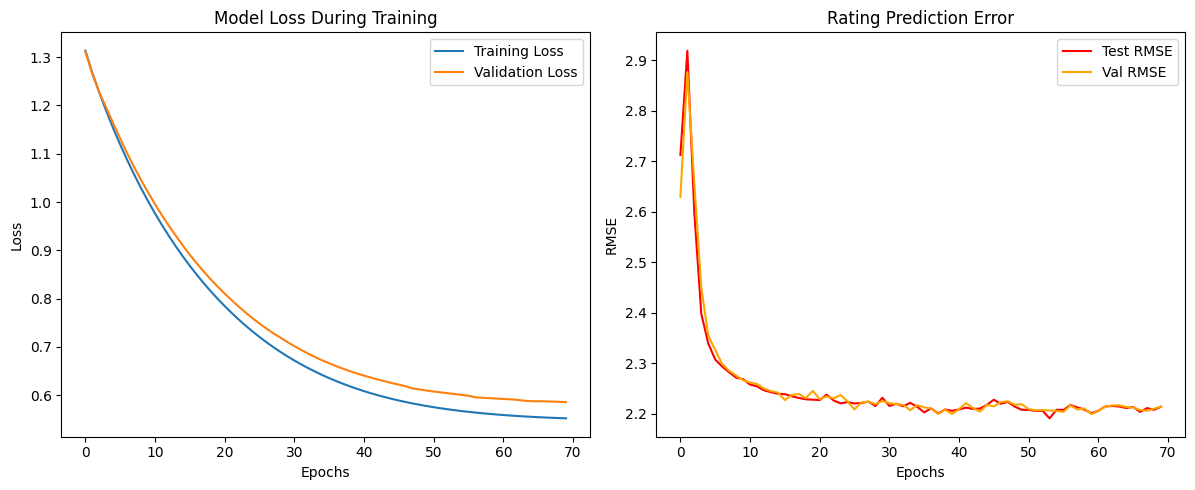

In [54]:
# Plot learning curves dengan validation metrics
plt.figure(figsize=(18, 5))  # Layout 3 subplot

# Plot 1: Loss curves
plt.subplot(1, 3, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot 2: RMSE
plt.subplot(1, 3, 2)
plt.plot(history['rmse'], label='Test RMSE', color='red')
plt.plot(history['val_rmse'], label='Val RMSE', color='orange')
plt.title('Rating Prediction Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# # Plot 3: HR dan NDCG
# plt.subplot(1, 3, 3)
# plt.plot(history['hr'], label='Test HR')
# plt.plot(history['ndcg'], label='Test NDCG')
# plt.title('Recommendation Metrics')
# plt.xlabel('Epochs')
# plt.ylabel('Score')
# plt.legend()


plt.tight_layout()
plt.show()

## **Test Model Performance and Comprehensive Evaluation**

In [62]:
# Load best model weights
# model.load_weights('dmf_best_model.h5')

# Evaluasi final & efek TopN
final_hr, final_ndcg, final_rmse = evaluate_model(model, test_ratings, test_negatives, topN)
print(f"Final metrics: HR = {final_hr:.4f}, NDCG = {final_ndcg:.4f}, RMSE = {final_rmse:.4f}")

# Evaluasi berbagai nilai TopN
topn_values = [5, 10, 15, 20]
results = []
for n in topn_values:
   hr, ndcg, rmse = evaluate_model(model, test_ratings, test_negatives, n)
   results.append([n, hr, ndcg, rmse])

# Tampilkan hasil
results_df = pd.DataFrame(results, columns=['TopN', 'HR', 'NDCG', 'RMSE'])
print("\nPerformance at different TopN values:")
print(results_df)

# Visualisasi
plt.subplot(1, 3, 1)
plt.plot(results_df['TopN'], results_df['HR'], marker='o')
plt.title('Hit Ratio at different TopN values')
plt.xlabel('TopN'); plt.ylabel('Hit Ratio'); plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(results_df['TopN'], results_df['NDCG'], marker='o', color='orange')
plt.title('NDCG at different TopN values')
plt.xlabel('TopN'); plt.ylabel('NDCG'); plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(results_df['TopN'], results_df['RMSE'], marker='o', color='red')
plt.title('RMSE at different TopN values')
plt.xlabel('TopN'); plt.ylabel('RMSE'); plt.grid(True)

plt.tight_layout()
plt.show()

Final metrics: HR = 0.9941, NDCG = 0.8027, RMSE = 2.2135


KeyboardInterrupt: 

In [ ]:
# ## Comprehensive Evaluation with Additional Metrics
# print("\n## Comprehensive Model Evaluation")
# print("Evaluating DMF with additional metrics...")

# # Evaluate model with threshold 0.7 (standard threshold)
# threshold = 0.7
# dmf_eval = evaluate_dmf_detailed(
#     model=model,
#     test_ratings=test_ratings,
#     test_negatives=test_negatives,
#     topN=topN,
#     threshold=threshold
# )
# print_dmf_evaluation_results(dmf_eval, topN)

# # Simple visualization of key metrics
# plt.figure(figsize=(12, 5))

# # Plot 1: Key metrics overview
# plt.subplot(1, 2, 1)
# metrics_names = ['HR', 'NDCG', 'RMSE']  # Removed MAE
# metrics_values = [dmf_eval['hr'], dmf_eval['ndcg'], dmf_eval['rmse']]  # Removed MAE value
# colors = ['blue', 'green', 'red']  # Removed orange for MAE

# plt.bar(metrics_names, metrics_values, color=colors)
# plt.title('DMF Performance - Key Metrics')
# plt.ylabel('Score')
# plt.grid(axis='y', linestyle='--', alpha=0.7)

# # Plot 2: Confusion matrix
# plt.subplot(1, 2, 2)
# cm = dmf_eval['confusion_matrix']
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
# plt.title(f'Confusion Matrix (Threshold={threshold})')
# plt.ylabel('Actual')
# plt.xlabel('Predicted')

# plt.tight_layout()
# plt.savefig('dmf_evaluation_summary.png')
# plt.show()

## **Get Recommendations**

## **Predict 1**

In [63]:
# Cek user ID yang tersedia
print("Daftar User ID yang tersedia:")
# Konversi ke int biasa untuk menghilangkan format np.int64
sample_users = [int(uid) for uid in list(user_to_index.keys())[:10]]
print(f"Contoh Beberapa User ID: {sample_users}")

# Menggunakan user ID spesifik
user_id = 1  # Menggunakan user ID langsung
print(f"Menggunakan User ID: {user_id}")

Daftar User ID yang tersedia:
Contoh Beberapa User ID: [1, 4, 9, 20, 23, 37, 47, 48, 53, 66]
Menggunakan User ID: 1


In [64]:
def get_recommendations_dmf(model, user_id, df_anime, df_score, user_to_index, index_to_anime, top_n=10):
    """
    Memberikan rekomendasi anime untuk user berdasarkan model DMF dengan perbandingan rating asli.
    """
    if user_id not in user_to_index:
        print(f"User ID {user_id} tidak ditemukan dalam dataset")
        return None
    
    # Dapatkan user index
    user_idx = user_to_index[user_id]
    
    # Siapkan data untuk prediksi
    all_items = np.arange(len(index_to_anime))
    user_input = np.full(len(all_items), user_idx)
    
    # Prediksi skor untuk semua anime
    print(f"Memprediksi rating untuk semua anime untuk user ID {user_id}...")
    predictions = model.predict(
        [user_input, all_items],
        batch_size=4096,
        verbose=1
    ).flatten()
    
    # Ambil data rating yang diberikan oleh user
    user_ratings = df_score[df_score['user_id'] == user_id]
    print(f"User ini telah menilai {len(user_ratings)} anime")
    
    # Scale predictions to full range 1-10
    # Cari min dan max nilai prediksi untuk normalisasi yang lebih baik
    min_pred = np.min(predictions)
    max_pred = np.max(predictions)
    
    # Normalisasi ke range [0,1] dahulu kemudian ke [1,10]
    if max_pred > min_pred:  # Hindari division by zero
        normalized_preds = (predictions - min_pred) / (max_pred - min_pred)
        scaled_preds = 1.0 + (normalized_preds * 9.0)  # Scale to [1,10]
    else:
        scaled_preds = np.full_like(predictions, 5.0)  # Default ke nilai tengah
    
    # Dapatkan anime_ids yang telah dinilai
    rated_anime_ids = user_ratings['anime_id'].tolist()
    
    # Konversi indeks prediksi ke anime_id dengan skala [1,10]
    anime_id_to_score = {index_to_anime[i]: score for i, score in zip(all_items, scaled_preds)}
    
    # Buat DataFrame untuk semua prediksi
    all_predictions = pd.DataFrame({
        'anime_id': list(anime_id_to_score.keys()),
        'Rating_Prediction': list(anime_id_to_score.values())
    })
    
    # Gabungkan dengan informasi anime
    all_predictions = all_predictions.merge(
        df_anime[['anime_id', 'Name', 'Genres', 'Score']], 
        on='anime_id'
    )
    
    # Pisahkan antara anime yang sudah dinilai dan belum dinilai
    rated_predictions = all_predictions[all_predictions['anime_id'].isin(rated_anime_ids)].copy()
    unrated_predictions = all_predictions[~all_predictions['anime_id'].isin(rated_anime_ids)].copy()
    
    # Jika ada anime yang sudah dinilai
    if len(rated_predictions) > 0:
        # Gabungkan dengan rating asli
        rated_predictions = rated_predictions.merge(
            user_ratings[['anime_id', 'rating']], 
            on='anime_id'
        ).rename(columns={'rating': 'User_Rating'})
        
        # Urutkan berdasarkan prediksi tertinggi
        rated_predictions = rated_predictions.sort_values('Rating_Prediction', ascending=False)
    
    # Urutkan dan ambil top-n rekomendasi untuk anime yang belum dinilai
    unrated_predictions = unrated_predictions.sort_values('Rating_Prediction', ascending=False).head(top_n)
    
    # Return both dataframes
    return rated_predictions, unrated_predictions

In [65]:
# Contoh penggunaan
user_id = 1

# Dapatkan rekomendasi
rated_predictions, unrated_predictions = get_recommendations_dmf(
    model=model,  # Model DMF yang sudah dilatih
    user_id=user_id,
    df_anime=df_anime,
    df_score=df_score,
    user_to_index=user_to_index,
    index_to_anime=index_to_anime,
    top_n=10
)

# Tampilkan hasil hanya untuk anime yang sudah dinilai
if len(rated_predictions) > 0:
    print(f"\nTop 10 Anime yang Sudah Dinilai oleh User ID: {user_id}")
    display(rated_predictions[['Name', 'Genres', 'Score', 'Rating_Prediction', 'User_Rating']].head(10))
    
    # Hitung error
    error = rated_predictions['Rating_Prediction'] - rated_predictions['User_Rating']
    print(f"\nEvaluasi untuk {len(rated_predictions)} anime yang dinilai:")
    print(f"RMSE: {np.sqrt(np.mean(error**2)):.4f}")
    print(f"MAE: {np.mean(np.abs(error)):.4f}")
else:
    print(f"\nUser ID {user_id} belum menilai anime apapun dalam dataset.")

Memprediksi rating untuk semua anime untuk user ID 1...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
User ini telah menilai 262 anime

Top 10 Anime yang Sudah Dinilai oleh User ID: 1


,Name,Genres,Score,Rating_Prediction,User_Rating
213,Death Note,"Supernatural, Suspense",8.62,10.000000,9
217,Code Geass: Hangyaku no Lelouch,"Action, Award Winning, Drama, Sci-Fi",8.70,9.773438,8
48,Fullmetal Alchemist,"Action, Adventure, Award Winning, Drama, Fantasy",8.11,9.601562,9
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,9.406250,10
67,Mononoke Hime,"Action, Adventure, Award Winning, Fantasy",8.67,9.382812,9
91,Sen to Chihiro no Kamikakushi,"Adventure, Award Winning, Supernatural",8.78,9.273438,10
242,Code Geass: Hangyaku no Lelouch R2,"Action, Award Winning, Drama, Sci-Fi",8.91,9.062500,6
194,Suzumiya Haruhi no Yuuutsu,"Award Winning, Comedy, Mystery, Sci-Fi",7.83,8.953125,10
171,Howl no Ugoku Shiro,"Adventure, Award Winning, Drama, Fantasy, Romance",8.66,8.921875,10
195,Ouran Koukou Host Club,"Comedy, Romance",8.16,8.882812,9



Evaluasi untuk 262 anime yang dinilai:
RMSE: 3.3110
MAE: 2.9454


In [66]:
# Filter hasil rekomendasi berdasarkan genre tertentu
genre_filter = "Action"  # Misalnya kita tertarik dengan anime genre Action

# Dapatkan semua rekomendasi untuk user terlebih dahulu
rated_predictions, _ = get_recommendations_dmf(
    model=model,  # Model DMF yang sudah dilatih
    user_id=user_id,
    df_anime=df_anime,
    df_score=df_score,
    user_to_index=user_to_index,
    index_to_anime=index_to_anime,
    top_n=10
)

# Filter berdasarkan genre dan hanya yang sudah diberi rating
dmf_genre_rated = rated_predictions[rated_predictions['Genres'].str.contains(genre_filter, na=False)]

# Urutkan berdasarkan prediksi rating tertinggi
dmf_genre_rated = dmf_genre_rated.sort_values(by='Rating_Prediction', ascending=False)

# Tampilkan hasil yang sudah dinilai oleh user
if len(dmf_genre_rated) > 0:
    print(f"\nTop 10 Anime Bergenre {genre_filter} yang Sudah Dinilai oleh User ID: {user_id}")
    display(dmf_genre_rated[['Name', 'Genres', 'Score', 'Rating_Prediction', 'User_Rating']].head(10))
    
    # Hitung error untuk anime bergenre ini yang sudah dinilai
    rmse_genre = np.sqrt(np.mean((dmf_genre_rated['Rating_Prediction'] - dmf_genre_rated['User_Rating'])**2))
    mae_genre = np.mean(np.abs(dmf_genre_rated['Rating_Prediction'] - dmf_genre_rated['User_Rating']))
    print(f"RMSE: {rmse_genre:.4f}, MAE: {mae_genre:.4f}")
else:
    print(f"\nUser belum menilai anime dengan genre {genre_filter}")

Memprediksi rating untuk semua anime untuk user ID 1...
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
User ini telah menilai 262 anime

Top 10 Anime Bergenre Action yang Sudah Dinilai oleh User ID: 1


,Name,Genres,Score,Rating_Prediction,User_Rating
217,Code Geass: Hangyaku no Lelouch,"Action, Award Winning, Drama, Sci-Fi",8.70,9.773438,8
48,Fullmetal Alchemist,"Action, Adventure, Award Winning, Drama, Fantasy",8.11,9.601562,9
0,Cowboy Bebop,"Action, Award Winning, Sci-Fi",8.75,9.406250,10
67,Mononoke Hime,"Action, Adventure, Award Winning, Fantasy",8.67,9.382812,9
242,Code Geass: Hangyaku no Lelouch R2,"Action, Award Winning, Drama, Sci-Fi",8.91,9.062500,6
42,Full Metal Panic? Fumoffu,"Action, Comedy",8.03,8.750000,10
229,Tengen Toppa Gurren Lagann,"Action, Adventure, Award Winning, Sci-Fi",8.63,8.718750,8
111,Elfen Lied,"Action, Drama, Horror, Romance, Supernatural",7.48,8.492188,8
15,Neon Genesis Evangelion,"Action, Avant Garde, Award Winning, Drama, Sci...",8.35,8.335938,10
112,FLCL,"Action, Avant Garde, Comedy, Sci-Fi",8.03,8.156250,8


RMSE: 3.1018, MAE: 2.6872


## **Predict 2**

Menghitung jarak antar vektor embeddings

In [59]:
def sq_dist(a, b):
    """
    Returns the squared distance between two vectors
    Args:
      a (ndarray (n,)): vector with n features
      b (ndarray (n,)): vector with n features
    Returns:
      d (float) : distance
    """
    d = np.sum(np.square(a - b))
    return d

In [60]:
# Ekstrak layer embedding dari model DMF untuk item/anime
# Buat model baru yang hanya mengambil item embedding
item_input = Input(shape=(1,), dtype='int32', name='item_input_extract')
item_embedding = model.get_layer('item_embedding')(item_input)
item_flat = Flatten()(item_embedding)

# Tambahkan layer dense jika perlu
for i in range(len(dmf.item_layers)):
    layer_name = f'item_layer{i+1}'
    item_layer = model.get_layer(layer_name)
    item_flat = item_layer(item_flat)  # Gunakan layer yang didapat, bukan string layer_name

# Buat model untuk ekstraksi embedding
item_model = Model(inputs=item_input, outputs=item_flat)
item_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ item_input_extract (InputLayer)      │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ item_embedding (Embedding)           │ (None, 1, 128)              │       3,187,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ item_layer1 (Dense)                  │ (None, 1024)                │         132,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ item_layer2 (Dense)                  │ (None, 64)                  │          65,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,385,536 (12.91 MB)

 Trainable params: 3,385,536 (12.91 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Ekstrak embeddings untuk semua anime
all_anime_ids = np.arange(len(index_to_anime))
anime_embeddings = item_model.predict(all_anime_ids, batch_size=4096, verbose=1)

print(f"Ukuran embeddings semua anime: {anime_embeddings.shape}")

In [ ]:
# Batasi jumlah anime untuk kecepatan perhitungan
count = 50  # jumlah anime yang akan ditampilkan
dim = len(anime_embeddings)

# Gunakan subset data untuk demonstrasi yang lebih cepat
subset_size = min(1000, dim)
anime_embeddings_subset = anime_embeddings[:subset_size]
dim = subset_size

print(f"Menggunakan {dim} anime untuk perhitungan kesamaan...")

# Hitung matrix jarak dengan pendekatan vectorized
from scipy.spatial.distance import pdist, squareform

# Hitung semua jarak sekaligus
pairwise_dists = pdist(anime_embeddings_subset, 'sqeuclidean')
dist_matrix = squareform(pairwise_dists)

# Masking diagonal (jarak anime dengan dirinya sendiri)
masked_dist = np.ma.masked_array(dist_matrix, mask=np.identity(dist_matrix.shape[0]))

print(f"Ukuran matrix jarak: {dist_matrix.shape}")
print(f"Nilai minimum jarak (anime yang paling mirip): {np.min(masked_dist)}")
print(f"Nilai maksimum jarak (anime yang paling berbeda): {np.max(masked_dist)}")

In [ ]:
# Tujuannya adalah mendapatkan 1 anime yang paling mirip dari setiap anime.
header = ["anime1", "genre1", "anime2", "genre2"]
similar_anime_pairs = []

for i in range(count):
    min_idx = np.argmin(masked_dist[i])  # Dapatkan index dengan nilai similarity terkecil
    anime1_id = int(df_anime.iloc[i]['anime_id'])
    anime2_id = int(df_anime.iloc[min_idx]['anime_id'])
    
    # Dapatkan informasi nama dan genre
    anime1_info = df_anime[df_anime['anime_id'] == anime1_id].iloc[0]
    anime2_info = df_anime[df_anime['anime_id'] == anime2_id].iloc[0]
    
    similar_anime_pairs.append([
        anime1_info['Name'], 
        anime1_info['Genres'],
        anime2_info['Name'], 
        anime2_info['Genres']
    ])

# Buat dan tampilkan dataframe hasil
similar_anime_df = pd.DataFrame(similar_anime_pairs, columns=header)
print("Anime yang Paling Mirip Berdasarkan Embeddings DMF:")
display(similar_anime_df)

 Fungsi untuk mencari anime yang mirip dengan anime tertentu:

In [ ]:
def find_similar_anime(anime_id, anime_embeddings, df_anime, top_n=10):
    """
    Mencari anime yang paling mirip dengan anime tertentu berdasarkan embeddings
    
    Parameters:
    - anime_id: ID anime yang jadi acuan
    - anime_embeddings: Matrix embeddings semua anime
    - df_anime: DataFrame berisi informasi anime
    - top_n: Jumlah anime mirip yang akan ditampilkan
    
    Returns:
    - DataFrame berisi anime yang mirip
    """
    # Cari indeks anime yang dimaksud
    anime_idx = np.where(df_anime['anime_id'] == anime_id)[0]
    
    if len(anime_idx) == 0:
        print(f"Anime dengan ID {anime_id} tidak ditemukan")
        return None
    
    anime_idx = anime_idx[0]
    anime_embedding = anime_embeddings[anime_idx]
    
    # Hitung jarak ke semua anime lain
    distances = np.array([sq_dist(anime_embedding, emb) for emb in anime_embeddings])
    
    # Masking anime itu sendiri
    distances[anime_idx] = np.inf
    
    # Ambil top-n anime dengan jarak terdekat
    closest_indices = np.argsort(distances)[:top_n]
    
    # Ambil informasi anime
    similar_anime = df_anime.iloc[closest_indices].copy()
    similar_anime['Distance'] = distances[closest_indices]
    
    return similar_anime

In [ ]:
# Pilih anime tertentu sebagai acuan
target_anime_id = 1  # Misalnya: Cowboy Bebop

# Tampilkan detail anime acuan
target_anime = df_anime[df_anime['anime_id'] == target_anime_id].iloc[0]
print(f"Anime Acuan: {target_anime['Name']} (ID: {target_anime_id})")
print(f"Genre: {target_anime['Genres']}")
print(f"Score: {target_anime['Score']}")
print("\nMencari anime yang mirip...")

# Cari anime yang mirip
similar_anime = find_similar_anime(target_anime_id, anime_embeddings, df_anime, top_n=10)

# Tampilkan hasil
if similar_anime is not None:
    print("\nTop 10 Anime yang Paling Mirip:")
    display(similar_anime[['Name', 'Genres', 'Score', 'Distance']])

## **Save and Load Model**

In [67]:
# Save model
model.save('dmf.h5')
print("Model saved as 'dmf.h5'")

# Test loading the model and making predictions
try:
    loaded_model = tf.keras.models.load_model('dmf.h5')
    print("Successfully loaded model")
    
    # Generate recommendations using loaded model
    print("Generating recommendations with loaded model...")
    recommendations = get_recommendations(loaded_model, sample_user_id, top_n=5)
    print("\nTop 5 Recommendations from loaded model:")
    for i, rec in enumerate(recommendations):
        print(f"{i+1}. {rec['name']} (Predicted Score: {rec['score']:.4f})")
except Exception as e:
    print(f"Error loading model: {e}")

Model saved as 'dmf.h5'
Error loading model: Error when deserializing class 'Dense' using config={'name': 'user_layer1', 'trainable': True, 'dtype': 'mixed_float16', 'units': 512, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'builtins', 'class_name': 'function', 'config': 'init_normal', 'registered_name': 'function'}, 'bias_initializer': {'module': 'builtins', 'class_name': 'function', 'config': 'init_normal', 'registered_name': 'function'}, 'kernel_regularizer': {'module': 'keras.regularizers', 'class_name': 'L2', 'config': {'l2': 0.003}, 'registered_name': None}, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}.

Exception encountered: Could not interpret initializer identifier: {'module': 'builtins', 'class_name': 'function', 'config': 'init_normal', 'registered_name': 'function'}


In [68]:
# Save model weights (bukan model utuh)
model.save_weights('dmf.weights.h5')  # Perbaikan: tambahkan .weights.h5 sebagai akhiran
print("Model weights saved as 'dmf.weights.h5'")

# Fungsi untuk membuat ulang model dan memuat weights
def load_dmf_model(weights_path):
    # Buat model DMF baru
    dmf_new = DMF(num_users=num_users,
                 num_items=num_animes,
                 user_layers=user_layers,
                 item_layers=item_layers,
                 lr=learning_rate,
                 train_matrix=None)  # Tidak perlu train_matrix untuk prediksi
                
    # Dapatkan model
    new_model = dmf_new.get_model()
    
    # Load weights
    new_model.load_weights(weights_path)
    
    return new_model

Model weights saved as 'dmf.weights.h5'


In [ ]:
# Test loading the model weights dan rebuild model
try:
    # Rebuild model dan load weights
    loaded_model = load_dmf_model('dmf.weights.h5')  # Perbaikan: sesuaikan nama file
    print("Successfully loaded model weights and rebuilt model")
    
    # Cek performa model yang dimuat
    hr, ndcg, rmse = evaluate_model(loaded_model, test_ratings, test_negatives, topN)
    print(f"Performa model: HR = {hr:.4f}, NDCG = {ndcg:.4f}, RMSE = {rmse:.4f}")
    
    # Generate recommendations menggunakan model yang dimuat
    user_id = 23  # Gunakan user ID contoh
    print(f"\nMenghasilkan rekomendasi untuk User ID: {user_id}")
    
    recommendations = get_recommendations_dmf(
        model=loaded_model,
        user_id=user_id,
        df_anime=df_anime,
        user_to_index=user_to_index,
        index_to_anime=index_to_anime,
        top_n=5
    )
    
    # Tampilkan rekomendasi
    if recommendations is not None:
        print("\nTop 5 Rekomendasi:")
        display(recommendations[['Name', 'Genres', 'Score', 'Prediction_Score']].head(5))
    
except Exception as e:
    print(f"Error loading model: {e}")

## **HYBRID RECOMMENDATION**

In [ ]:
# Import Libraries
import joblib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


In [ ]:
# Class untuk hybrid model dengan kalibrasi yang lebih seimbang
class HybridAnimeRecommendation:
    def __init__(self, dmf_model, user_scaler, anime_scaler, target_scaler, 
                 user_data_vecs, anime_data_vecs, alpha=0.4):
        """
        Model hybrid yang menggabungkan DMF dengan Neural Content-Based Filtering
        
        Args:
            dmf_model: Model DMF yang sudah dilatih
            user_scaler: Scaler untuk normalisasi data user
            anime_scaler: Scaler untuk normalisasi data anime
            target_scaler: Scaler untuk transformasi nilai target
            user_data_vecs: Vector representasi dari user
            anime_data_vecs: Vector representasi dari anime
            alpha: Bobot untuk DMF (1-alpha adalah bobot untuk NCBF)
        """
        self.dmf_model = dmf_model
        self.user_scaler = user_scaler
        self.anime_scaler = anime_scaler
        self.target_scaler = target_scaler
        self.user_data_vecs = user_data_vecs
        self.anime_data_vecs = anime_data_vecs
        self.alpha = alpha
        
        print(f"DMF weight: {self.alpha}, NCBF weight: {1-self.alpha}")
        
        # Selalu build model NCBF dan muat weights secara terpisah
        # Ini lebih stabil daripada load_model() dengan Lambda layer
        self.ncbf_model = self._build_ncbf_model()
        try:
            self.ncbf_model.load_weights('content_based.h5')
            print("NCBF weights loaded successfully")
        except Exception as e:
            print(f"Could not load weights: {e}")
            print("Using model without pretrained weights")
    
    def _build_ncbf_model(self):
        """Membuat model Neural Content-Based Filtering"""
        # Definisikan arsitektur yang sama dengan model NCBF asli
        num_outputs = 10
        
        # User Neural Network
        user_NN = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(num_outputs)
        ])

        # Anime Neural Network 
        anime_NN = tf.keras.models.Sequential([
            tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.Dense(num_outputs)
        ])

        # Input untuk user (sesuaikan dengan dimensi user vector)
        input_user = tf.keras.layers.Input(shape=(self.user_data_vecs.shape[1],))
        vu = user_NN(input_user)
        vu = L2NormalizeLayer()(vu)  # Normalisasi L2

        # Input untuk anime (sesuaikan dengan dimensi anime vector)
        input_anime = tf.keras.layers.Input(shape=(self.anime_data_vecs.shape[1],))
        va = anime_NN(input_anime)
        va = L2NormalizeLayer()(va)  # Normalisasi L2

        # Dot product antara user dan anime
        output = tf.keras.layers.Dot(axes=1)([vu, va])

        # Model akhir
        model = tf.keras.Model([input_user, input_anime], output)
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                     loss='mean_absolute_error')
        
        return model
    
    def _calibrate_prediction(self, pred, anime_id=None):
        """
        Kalibrasi prediksi agar sesuai dengan skala rating MAL (7-9)
        dengan pendekatan yang lebih moderat
        
        Args:
            pred: Prediksi rating mentah
            anime_id: ID anime untuk kalibrasi khusus berdasarkan anime (opsional)
            
        Returns:
            float: Prediksi yang sudah dikalibrasi
        """
        # Kalibrasi yang lebih moderate
        calibrated = pred * 1.45 + 1.5  # Kalibrasi lebih moderat
        
        # Pastikan tidak melebihi 9.7 (bukan perfect 10)
        calibrated = min(calibrated, 9.7)
        
        # Kalibrasi tambahan berdasarkan rentang prediksi
        if pred < 2.0:  # Prediksi sangat rendah
            # Kurangi efek kalibrasi untuk prediksi rendah
            calibrated = calibrated * 0.9
        elif pred > 5.0:  # Prediksi sangat tinggi
            # Batasi prediksi tertinggi ke level lebih realistis
            calibrated = min(calibrated, 9.3)
        
        return calibrated
        
    def predict(self, user_id, anime_id):
        """
        Memprediksi rating untuk pasangan user-anime tertentu
        
        Args:
            user_id: ID user
            anime_id: ID anime
            
        Returns:
            float: Rating prediksi
        """
        # Prediksi dari DMF
        dmf_pred = self.predict_dmf(user_id, anime_id)
        
        # Gunakan hanya DMF jika alpha = 1.0
        if self.alpha == 1.0:
            return self._calibrate_prediction(dmf_pred, anime_id)
            
        # Prediksi dari Neural Content-Based
        try:
            ncbf_pred = self.predict_ncbf(user_id, anime_id)
            
            # Boost moderat berdasarkan skor actual anime dari MAL
            anime_actual_score = 0
            anime_data = df_anime[df_anime['anime_id'] == anime_id]
            if not anime_data.empty and not np.isnan(anime_data.iloc[0]['Score']):
                anime_actual_score = anime_data.iloc[0]['Score']
                # Boost moderat untuk anime dengan skor tinggi
                if anime_actual_score >= 8.5:
                    boost = 0.3  # Boost lebih kecil
                elif anime_actual_score >= 8.0:
                    boost = 0.2
                elif anime_actual_score >= 7.5:
                    boost = 0.1
                else:
                    boost = 0
                
                hybrid_pred = self.alpha * dmf_pred + (1 - self.alpha) * ncbf_pred + boost
            else:
                # Default weighting
                hybrid_pred = self.alpha * dmf_pred + (1 - self.alpha) * ncbf_pred
            
            # Kalibrasi hasil
            return self._calibrate_prediction(hybrid_pred, anime_id)
        except Exception as e:
            # Jika ada masalah dengan NCBF, gunakan hanya DMF
            return self._calibrate_prediction(dmf_pred, anime_id)
    
    def predict_dmf(self, user_id, anime_id):
        """Prediksi menggunakan model DMF"""
        # Convert user_id dan anime_id ke format internal model
        user_idx = user_to_index.get(user_id)
        anime_idx = anime_to_index.get(anime_id)
        
        if user_idx is None or anime_idx is None:
            return 0.0  # Tidak ditemukan
        
        # Prediksi menggunakan model DMF
        pred = self.dmf_model.predict(
            [np.array([user_idx]), np.array([anime_idx])],
            verbose=0
        )[0][0]
        
        # Konversi ke skala 1-10
        pred = pred * 10
        
        return pred
    
    def predict_ncbf(self, user_id, anime_id):
        """Prediksi menggunakan model Neural Content-Based"""
        try:
            # Cari user di average_user_df_score
            user_data = average_user_df_score[average_user_df_score['user_id'] == user_id]
            
            if len(user_data) == 0:
                return 0.0  # User tidak ditemukan
                
            # Dapatkan vektor user
            user_vec = user_data.iloc[:, 1:].values[0].reshape(1, -1)
            
            # Cari anime di dataset
            anime_data = anime_one_hot_df[anime_one_hot_df['anime_id'] == anime_id]
            
            if len(anime_data) == 0:
                return 0.0  # Anime tidak ditemukan
                
            # Dapatkan vektor anime
            anime_vec = anime_data.iloc[:, 1:].values[0].reshape(1, -1)
            
            # Normalisasi vektors
            user_vec_scaled = self.user_scaler.transform(user_vec)
            anime_vec_scaled = self.anime_scaler.transform(anime_vec)
            
            # Prediksi menggunakan model NCBF
            pred_scaled = self.ncbf_model.predict(
                [user_vec_scaled, anime_vec_scaled],
                verbose=0
            )[0][0]
            
            # Denormalisasi hasil
            pred = self.target_scaler.inverse_transform([[pred_scaled]])[0][0]
            
            return pred
        except Exception as e:
            # Jika ada masalah, gunakan DMF saja
            return 0.0
    
    def recommend_for_user(self, user_id, top_n=10, filter_watched=True, batch_size=256):
        """
        Memberikan rekomendasi anime untuk user tertentu dengan batch processing
        
        Args:
            user_id: ID user
            top_n: Jumlah rekomendasi
            filter_watched: Apakah perlu menyaring anime yang sudah ditonton
            batch_size: Ukuran batch untuk prediksi
            
        Returns:
            DataFrame: Anime yang direkomendasikan
        """
        print(f"Generating recommendations for user {user_id}...")
        
        # Dapatkan semua anime ID dari dataset
        all_anime_ids = df_anime['anime_id'].tolist()
        
        # Jika perlu filter, ambil anime yang sudah ditonton
        watched_anime = set()
        if filter_watched:
            user_idx = user_to_index.get(user_id)
            if user_idx is not None:
                for i in range(data_matrix.shape[1]):
                    if data_matrix[user_idx, i] > 0:
                        anime_id = index_to_anime.get(i)
                        if anime_id:
                            watched_anime.add(anime_id)
        
        # Filter anime yang belum ditonton
        candidate_anime_ids = [a_id for a_id in all_anime_ids if not (filter_watched and a_id in watched_anime)]
        print(f"Found {len(candidate_anime_ids)} candidate anime after filtering watched.")
        
        # Prefiter: prioritaskan anime dengan rating tinggi terlebih dahulu (minimal separuh prioritas untuk semua anime)
        top_rated_anime = df_anime[df_anime['Score'] >= 7.5]['anime_id'].tolist()
        top_rated_unwatched = [a_id for a_id in top_rated_anime if a_id in candidate_anime_ids]
        
        # Untuk mempercepat proses, batasi kandidat jika terlalu banyak
        if len(candidate_anime_ids) > 5000:
            print(f"Limiting candidates: prioritizing {len(top_rated_unwatched)} top-rated anime + random selection")
            import random
            random.seed(42)  # Untuk hasil yang konsisten
            # Ambil semua anime top-rated + random lainnya hingga total 5000
            remaining_slots = 5000 - len(top_rated_unwatched)
            other_candidates = [a_id for a_id in candidate_anime_ids if a_id not in top_rated_unwatched]
            sampled_others = random.sample(other_candidates, min(remaining_slots, len(other_candidates)))
            candidate_anime_ids = top_rated_unwatched + sampled_others
        
        # Prediksi dengan batch processing
        predictions = []
        total_batches = (len(candidate_anime_ids) + batch_size - 1) // batch_size
        
        # Proses dalam batch
        for batch_num in range(total_batches):
            start_idx = batch_num * batch_size
            end_idx = min(start_idx + batch_size, len(candidate_anime_ids))
            batch_anime_ids = candidate_anime_ids[start_idx:end_idx]
            
            # Progress update
            if batch_num % 10 == 0:
                print(f"Processing batch {batch_num+1}/{total_batches}...")
            
            # Individual predictions for this batch
            batch_predictions = []
            for anime_id in batch_anime_ids:
                # Hybrid predict dengan kalibrasi
                pred = self.predict(user_id, anime_id)
                if pred > 0:  # Hanya tambahkan jika prediksi valid
                    batch_predictions.append((anime_id, pred))
            
            # Add predictions to results
            predictions.extend(batch_predictions)
        
        # Urutkan berdasarkan prediksi
        predictions.sort(key=lambda x: x[1], reverse=True)
        
        # Hitung statistik prediksi untuk analisis
        pred_values = [p[1] for p in predictions]
        if pred_values:
            min_pred = min(pred_values)
            max_pred = max(pred_values)
            avg_pred = sum(pred_values) / len(pred_values)
            print(f"Prediction stats - Min: {min_pred:.2f}, Max: {max_pred:.2f}, Avg: {avg_pred:.2f}")
        
        # Ambil top-n
        top_predictions = predictions[:top_n]
        
        # Jika tidak ada rekomendasi, gunakan fallback ke anime populer/rating tinggi
        if not top_predictions:
            print("Tidak ada rekomendasi yang cocok, menggunakan anime populer sebagai fallback")
            top_anime = df_anime.sort_values('Favorites', ascending=False).head(top_n)
            top_predictions = [(row['anime_id'], row['Score']) 
                              for _, row in top_anime.iterrows()]
        
        # Dapatkan data anime
        top_anime_ids = [p[0] for p in top_predictions]
        recommended_anime = df_anime[df_anime['anime_id'].isin(top_anime_ids)].copy()
        
        # Tambahkan skor prediksi
        anime_to_score = {anime_id: score for anime_id, score in top_predictions}
        recommended_anime['Prediction_Score'] = recommended_anime['anime_id'].map(anime_to_score)
        
        # Urutkan berdasarkan prediksi
        recommended_anime = recommended_anime.sort_values('Prediction_Score', ascending=False)
        
        return recommended_anime[['Name', 'Genres', 'Score', 'Prediction_Score']]

In [ ]:
# Import library yang diperlukan
import tensorflow as tf
import numpy as np
import pandas as pd
import joblib
from tensorflow.keras.regularizers import l2

# Custom layer for L2 normalization
@keras.saving.register_keras_serializable(package="ContentBased")
class L2NormalizeLayer(tf.keras.layers.Layer):
    def __init__(self, axis=1, **kwargs):
        super(L2NormalizeLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        return {'axis': self.axis}

# Load Scalers
user_scaler = joblib.load('user_scaler.gz')
anime_scaler = joblib.load('anime_scaler.gz')
target_scaler = joblib.load('target_scaler.gz')

# Load Vector Data
user_data = np.load('user_vector.npy')
anime_data = np.load('anime_vector.npy')

print(f"User vector shape: {user_data.shape}")
print(f"Anime vector shape: {anime_data.shape}")

# Instantiate Hybrid Model dengan alpha=0.6
hybrid_model = HybridAnimeRecommendation(
    dmf_model=model,  # Model DMF yang sudah dilatih
    user_scaler=user_scaler, 
    anime_scaler=anime_scaler,
    target_scaler=target_scaler,
    user_data_vecs=user_data,
    anime_data_vecs=anime_data,
    alpha=0.4  # DMF, 1-Aplha NCBF
)

# Coba buat rekomendasi
user_id = 23  # Contoh user ID
recommendations = hybrid_model.recommend_for_user(
    user_id=user_id, 
    top_n=20,
    filter_watched=True,
    batch_size=256  # Batch size untuk kecepatan
)

print(f"\nTop 20 Rekomendasi Hybrid untuk User ID: {user_id}")
display(recommendations[['Name', 'Genres', 'Score', 'Prediction_Score']])

# Filter berdasarkan genre
genre = "Action"
action_anime = recommendations[recommendations['Genres'].str.contains(genre)]
print(f"\nTop Rekomendasi Anime {genre} untuk User ID: {user_id}")
display(action_anime[['Name', 'Genres', 'Score', 'Prediction_Score']])

In [ ]:
# # Import library yang diperlukan
# import tensorflow as tf
# from tensorflow.keras.regularizers import l2

# # Load Scalers
# user_scaler = joblib.load('user_scaler.gz')
# anime_scaler = joblib.load('anime_scaler.gz')
# target_scaler = joblib.load('target_scaler.gz')

# # Load Vector Data
# user_data_vecs = np.load('user_vector.npy')
# anime_data_vecs = np.load('anime_vector.npy')

# # Instantiate Hybrid Model
# hybrid_model = HybridAnimeRecommendation(
#     dmf_model=model,  # Model DMF yang sudah dilatih dan ada di memori
#     user_scaler=user_scaler, 
#     anime_scaler=anime_scaler,
#     target_scaler=target_scaler,
#     user_data_vecs=user_data_vecs,
#     anime_data_vecs=anime_data_vecs,
#     alpha=0.7  # 70% DMF, 30% NCBF
# )

# # Coba buat rekomendasi
# user_id = 23  # Contoh user ID
# recommendations = hybrid_model.recommend_for_user(user_id, top_n=10)
# print(f"\nTop 10 Rekomendasi Hybrid untuk User ID: {user_id}")
# display(recommendations[['Name', 'Genres', 'Score', 'Prediction_Score']])